## PRIM with MORDM Results

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from SALib.analyze import sobol
import warnings
from ema_workbench.analysis import feature_scoring
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
import ema_workbench.em_framework.optimization
from ema_workbench.em_framework.optimization import to_problem, epsilon_nondominated, EpsilonProgress, ArchiveLogger
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    perform_experiments,
    Samplers,
)

from ema_workbench.analysis import prim
from dike_model_function import DikeNetwork
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time
from ema_workbench.analysis import prim
from ema_workbench.em_framework.parameters import Constant
import pickle
warnings.filterwarnings("ignore")
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [10]:
# Initialize the model
dike_model, planning_steps = get_model_for_problem_formulation(2)
# Retrieve MORDM results
experiments = pd.read_csv('Results/Final_policies_experiments.csv')
outcomes = pd.read_csv('Results/Final_policies_outcomes.csv')
# Polcies and drop duplicate rows
policy_outcomes = experiments[[pol.name for pol in dike_model.levers if pol.name in experiments.columns]]
policy_outcomes.drop_duplicates(inplace=True)

In [15]:
experiments
outcomes

,Unnamed: 0,Minimum Water Level,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
0,0,4.538700,1.662246e+08,1.785313e+08,30700000.0,0.000000,0.131240
1,1,5.250970,4.058218e+08,1.785313e+08,30700000.0,0.000000,0.331188
2,2,4.538477,0.000000e+00,1.785313e+08,30700000.0,0.000000,0.000000
3,3,4.684503,6.593431e+07,1.785313e+08,30700000.0,0.000000,0.051432
4,4,4.668011,1.038203e+08,1.785313e+08,30700000.0,0.000000,0.110117
...,...,...,...,...,...,...,...
77995,77995,5.406607,5.628202e+07,1.144564e+08,267200000.0,3952.496753,0.006904
77996,77996,4.418700,3.705367e+06,1.144564e+08,267200000.0,207.905330,0.000544
77997,77997,5.130970,2.169756e+07,1.144564e+08,267200000.0,245.269159,0.001493
77998,77998,5.130970,0.000000e+00,1.144564e+08,267200000.0,0.000000,0.000000


In [44]:
cleaned_experiments = experiments.drop(
    columns=experiments.columns[
        experiments.columns.str.contains('Unnamed: 0|DikeIncrease|EWS_DaysToThreat|RfR')
    ]
)

cleaned_experiments.head()

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2,scenario,policy,model
0,38,144.941345,1.0,0.394920,311.407187,1.0,0.244993,118.479031,1.5,0.057390,...,0.017466,187.232650,1.5,0.133344,3.5,3.5,3.5,1,0,dikesnet
1,116,229.430620,1.5,0.283332,119.963173,1.5,0.820142,243.799559,1.0,0.565996,...,0.735199,226.005971,1.5,0.054701,4.5,2.5,3.5,2,0,dikesnet
2,1,345.356021,10.0,0.896687,210.716111,10.0,0.887580,305.966970,1.0,0.637479,...,0.548144,78.097688,1.0,0.736709,3.5,4.5,2.5,3,0,dikesnet
3,46,246.219200,10.0,0.574097,303.567106,1.5,0.093844,57.963694,1.5,0.709233,...,0.328651,164.609994,10.0,0.420088,3.5,1.5,1.5,4,0,dikesnet
4,10,272.859765,1.5,0.920711,120.048411,1.5,0.298038,63.539416,1.5,0.113366,...,0.740394,271.180863,1.0,0.096692,2.5,3.5,3.5,5,0,dikesnet


[MainProcess/INFO] column model dropped from analysis because it has only one category


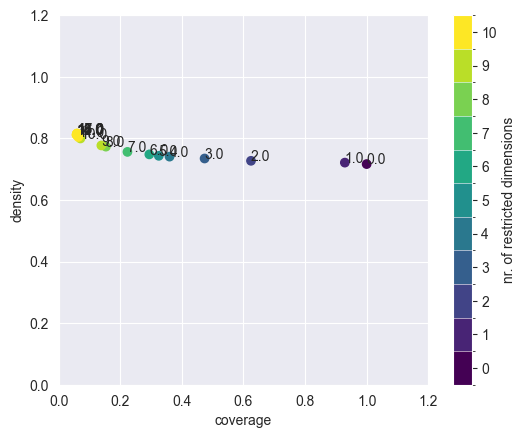

In [50]:
# === Define target for PRIM ===
target = (outcomes['Minimum Water Level'] < 4.8)

prim_rob = prim.Prim(cleaned_experiments,target, threshold=0.8,peel_alpha=0.1)
box1 = prim_rob.find_box()
box1.show_tradeoff(annotated=True)
plt.show()

In [46]:
print(target.sum())        # Total number of True values
print(len(target))         # Total number of cases
print(np.unique(target))   # Should be [True, False]

55879
78000
[False  True]


In [ ]:
# (Manually) select a box that has a nice coverage and density
#pd.DataFrame(box1.inspect(17, style='data')[0][1]).to_csv('data\A5_space_Prim3.csv')

coverage        0.624492
density         0.727000
id              2.000000
k           34896.000000
mass            0.615385
mean            0.727000
n           48000.000000
res_dim         2.000000
Name: 2, dtype: float64

          box 2                           
            min    max  qp value  qp value
A.4_Brate   1.0   5.75       NaN  0.002048
policy      1.0  12.00  0.010908       NaN



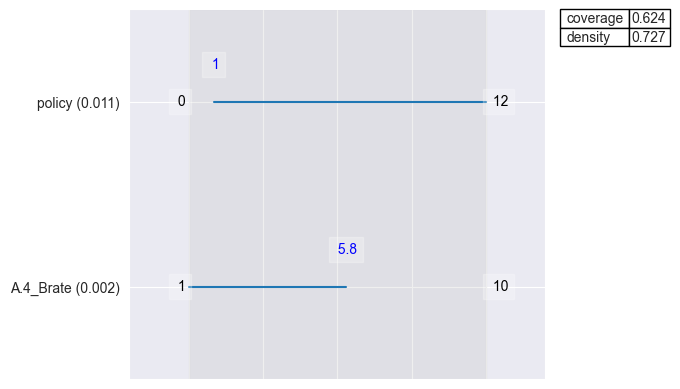

In [52]:
# choose a box that has moderate to high coverage (captures many good cases)
# and higher density

point = 2
# Inspect top box
box1.inspect(point)
box1.inspect(point, style='graph')
plt.show()

In [51]:
box1.resample(point)

[MainProcess/INFO] resample 0


KeyError: '[1, 3, 4, 5, 8, 9, 14, 16, 19, 21, 22, 24, 25, 26, 32, 34, 35, 38, 41, 43, 47, 50, 51, 52, 54, 55, 56, 57, 58, 61, 63, 64, 65, 66, 68, 69, 72, 73, 74, 76, 79, 82, 84, 85, 88, 89, 90, 91, 92, 93, 95, 96, 98, 100, 105, 106, 109, 111, 112, 113, 117, 118, 121, 128, 129, 130, 132, 133, 134, 135, 136, 137, 145, 146, 147, 149, 152, 153, 156, 157, 158, 159, 165, 167, 171, 172, 175, 176, 178, 180, 181, 182, 183, 185, 187, 188, 190, 191, 193, 194, 196, 198, 200, 202, 203, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 225, 226, 227, 228, 229, 230, 232, 234, 236, 238, 241, 242, 244, 245, 246, 255, 256, 257, 258, 259, 260, 261, 262, 265, 267, 269, 270, 274, 275, 280, 281, 282, 283, 285, 286, 287, 288, 289, 295, 296, 297, 298, 300, 301, 304, 307, 308, 310, 311, 315, 317, 319, 323, 325, 327, 329, 331, 332, 335, 336, 340, 344, 345, 347, 348, 351, 352, 353, 361, 363, 364, 370, 371, 372, 373, 374, 384, 388, 389, 390, 393, 395, 397, 398, 401, 402, 407, 409, 410, 411, 412, 415, 416, 418, 421, 423, 430, 431, 434, 435, 436, 437, 442, 445, 453, 454, 455, 460, 463, 464, 467, 468, 470, 472, 476, 477, 480, 484, 489, 492, 494, 501, 502, 503, 507, 508, 510, 511, 512, 513, 514, 515, 516, 518, 520, 522, 525, 527, 528, 531, 534, 536, 537, 543, 547, 548, 550, 551, 552, 556, 557, 558, 559, 560, 561, 562, 564, 568, 570, 572, 573, 576, 577, 578, 579, 580, 581, 584, 586, 587, 588, 592, 593, 594, 595, 596, 597, 599, 600, 601, 602, 604, 605, 606, 607, 610, 612, 613, 618, 619, 628, 631, 633, 635, 637, 638, 639, 641, 645, 647, 649, 650, 652, 654, 655, 658, 659, 661, 662, 664, 666, 667, 668, 669, 670, 672, 675, 676, 678, 679, 682, 683, 686, 688, 689, 690, 691, 692, 695, 697, 698, 703, 705, 706, 709, 710, 716, 717, 719, 723, 725, 727, 729, 731, 737, 741, 742, 744, 746, 748, 753, 755, 757, 759, 764, 765, 766, 768, 770, 772, 773, 775, 776, 780, 785, 787, 788, 790, 792, 793, 794, 797, 798, 799, 801, 804, 806, 807, 808, 810, 812, 813, 816, 820, 821, 823, 825, 827, 828, 831, 832, 834, 835, 840, 846, 847, 848, 850, 851, 852, 853, 856, 858, 861, 862, 865, 866, 867, 868, 869, 879, 884, 885, 886, 888, 889, 893, 895, 897, 898, 899, 900, 902, 905, 906, 907, 910, 916, 917, 918, 919, 920, 923, 925, 926, 927, 929, 931, 933, 935, 938, 941, 945, 947, 953, 954, 955, 959, 960, 963, 965, 966, 968, 969, 970, 971, 973, 976, 978, 981, 982, 984, 985, 986, 988, 991, 992, 996, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1009, 1010, 1011, 1012, 1013, 1015, 1016, 1018, 1021, 1022, 1023, 1024, 1025, 1026, 1030, 1031, 1036, 1037, 1038, 1039, 1040, 1042, 1043, 1045, 1046, 1047, 1048, 1053, 1054, 1055, 1056, 1058, 1059, 1060, 1061, 1062, 1063, 1069, 1070, 1073, 1076, 1077, 1079, 1082, 1083, 1084, 1085, 1086, 1090, 1095, 1096, 1105, 1107, 1115, 1116, 1117, 1118, 1119, 1121, 1122, 1123, 1124, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1136, 1137, 1138, 1141, 1142, 1143, 1144, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1161, 1163, 1164, 1165, 1166, 1169, 1172, 1177, 1179, 1181, 1185, 1187, 1188, 1190, 1191, 1193, 1195, 1197, 1199, 1201, 1202, 1205, 1206, 1207, 1208, 1209, 1210, 1213, 1214, 1215, 1217, 1218, 1219, 1220, 1222, 1223, 1226, 1227, 1233, 1234, 1236, 1238, 1239, 1240, 1245, 1246, 1247, 1252, 1255, 1257, 1260, 1262, 1265, 1269, 1271, 1272, 1274, 1275, 1277, 1279, 1280, 1285, 1286, 1287, 1288, 1293, 1295, 1297, 1298, 1299, 1300, 1301, 1304, 1306, 1308, 1309, 1310, 1311, 1314, 1315, 1319, 1322, 1323, 1324, 1328, 1329, 1331, 1332, 1334, 1337, 1338, 1339, 1340, 1341, 1344, 1347, 1349, 1354, 1356, 1361, 1362, 1367, 1368, 1369, 1371, 1373, 1377, 1378, 1379, 1380, 1381, 1382, 1384, 1385, 1388, 1391, 1392, 1394, 1400, 1403, 1404, 1410, 1411, 1413, 1416, 1424, 1425, 1426, 1428, 1429, 1431, 1433, 1435, 1436, 1438, 1441, 1442, 1444, 1445, 1446, 1448, 1449, 1450, 1451, 1454, 1455, 1456, 1459, 1460, 1461, 1462, 1466, 1467, 1471, 1478, 1480, 1481, 1483, 1485, 1486, 1487, 1488, 1491, 1493, 1494, 1495, 1498, 1499, 1500, 1501, 1505, 1506, 1511, 1514, 1515, 1516, 1517, 1520, 1521, 1523, 1524, 1525, 1529, 1530, 1532, 1534, 1535, 1537, 1540, 1542, 1544, 1545, 1546, 1548, 1550, 1551, 1552, 1553, 1554, 1555, 1557, 1558, 1559, 1560, 1562, 1563, 1564, 1565, 1567, 1571, 1572, 1573, 1574, 1575, 1582, 1583, 1585, 1587, 1588, 1589, 1590, 1591, 1592, 1594, 1596, 1601, 1602, 1603, 1607, 1609, 1612, 1615, 1621, 1623, 1624, 1626, 1628, 1630, 1633, 1634, 1636, 1637, 1642, 1645, 1646, 1649, 1651, 1654, 1655, 1657, 1658, 1659, 1662, 1663, 1664, 1666, 1669, 1671, 1672, 1673, 1674, 1677, 1683, 1684, 1685, 1688, 1689, 1690, 1691, 1692, 1696, 1698, 1703, 1704, 1706, 1707, 1708, 1712, 1718, 1719, 1721, 1722, 1724, 1725, 1726, 1727, 1729, 1730, 1731, 1736, 1737, 1738, 1739, 1742, 1746, 1747, 1748, 1750, 1751, 1757, 1761, 1763, 1765, 1766, 1767, 1768, 1773, 1776, 1778, 1781, 1782, 1783, 1788, 1789, 1791, 1792, 1795, 1796, 1799, 1801, 1806, 1810, 1811, 1812, 1814, 1819, 1820, 1822, 1825, 1828, 1829, 1831, 1833, 1836, 1837, 1839, 1840, 1843, 1847, 1851, 1854, 1858, 1860, 1861, 1862, 1863, 1867, 1869, 1871, 1872, 1873, 1874, 1875, 1876, 1877, 1881, 1884, 1885, 1886, 1887, 1888, 1889, 1891, 1893, 1896, 1897, 1898, 1901, 1906, 1911, 1914, 1916, 1918, 1920, 1921, 1922, 1923, 1924, 1925, 1927, 1928, 1929, 1932, 1933, 1934, 1938, 1941, 1942, 1943, 1944, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1961, 1962, 1963, 1965, 1968, 1971, 1972, 1973, 1974, 1975, 1977, 1978, 1981, 1982, 1985, 1988, 1989, 1997, 1998, 2000, 2001, 2002, 2003, 2005, 2008, 2009, 2011, 2017, 2018, 2020, 2021, 2022, 2023, 2026, 2029, 2031, 2036, 2038, 2039, 2042, 2043, 2047, 2054, 2055, 2056, 2058, 2059, 2060, 2063, 2066, 2067, 2068, 2069, 2070, 2073, 2075, 2076, 2081, 2082, 2083, 2085, 2087, 2092, 2093, 2096, 2097, 2100, 2102, 2103, 2106, 2108, 2109, 2113, 2120, 2122, 2125, 2126, 2130, 2131, 2133, 2135, 2137, 2138, 2139, 2140, 2141, 2144, 2145, 2146, 2148, 2149, 2151, 2152, 2155, 2157, 2161, 2162, 2167, 2169, 2171, 2176, 2178, 2179, 2180, 2182, 2183, 2184, 2186, 2189, 2191, 2193, 2194, 2195, 2199, 2201, 2202, 2204, 2205, 2211, 2214, 2215, 2217, 2220, 2222, 2226, 2228, 2229, 2231, 2233, 2235, 2236, 2238, 2242, 2243, 2244, 2246, 2247, 2248, 2249, 2251, 2252, 2253, 2254, 2255, 2258, 2259, 2260, 2264, 2265, 2267, 2269, 2270, 2275, 2277, 2278, 2280, 2281, 2285, 2288, 2290, 2293, 2294, 2296, 2297, 2300, 2302, 2303, 2307, 2308, 2309, 2310, 2314, 2315, 2316, 2320, 2323, 2326, 2330, 2336, 2337, 2339, 2342, 2343, 2345, 2346, 2347, 2348, 2349, 2350, 2351, 2352, 2353, 2354, 2357, 2358, 2359, 2360, 2361, 2362, 2364, 2365, 2367, 2371, 2372, 2375, 2379, 2382, 2385, 2386, 2390, 2391, 2393, 2395, 2396, 2397, 2398, 2400, 2405, 2408, 2409, 2412, 2416, 2418, 2419, 2421, 2423, 2425, 2426, 2427, 2428, 2429, 2432, 2434, 2436, 2442, 2445, 2446, 2448, 2451, 2455, 2457, 2462, 2463, 2465, 2466, 2467, 2468, 2472, 2474, 2475, 2478, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2490, 2494, 2497, 2498, 2499, 2500, 2502, 2504, 2505, 2508, 2509, 2511, 2514, 2520, 2524, 2525, 2528, 2529, 2530, 2531, 2532, 2535, 2538, 2540, 2541, 2544, 2546, 2548, 2549, 2552, 2556, 2558, 2562, 2563, 2564, 2567, 2570, 2571, 2572, 2574, 2576, 2577, 2578, 2582, 2583, 2585, 2586, 2587, 2589, 2590, 2591, 2593, 2596, 2599, 2600, 2602, 2603, 2606, 2607, 2608, 2609, 2610, 2611, 2613, 2614, 2615, 2616, 2617, 2619, 2620, 2622, 2623, 2625, 2626, 2633, 2635, 2636, 2640, 2642, 2644, 2646, 2649, 2650, 2655, 2657, 2658, 2659, 2660, 2661, 2662, 2664, 2666, 2667, 2668, 2670, 2671, 2672, 2673, 2674, 2675, 2676, 2677, 2678, 2681, 2683, 2684, 2686, 2687, 2688, 2689, 2692, 2694, 2696, 2698, 2700, 2702, 2707, 2709, 2710, 2713, 2715, 2718, 2721, 2722, 2723, 2725, 2727, 2728, 2730, 2733, 2735, 2737, 2738, 2739, 2741, 2744, 2746, 2748, 2749, 2750, 2751, 2754, 2762, 2763, 2766, 2767, 2769, 2770, 2772, 2773, 2774, 2776, 2781, 2782, 2786, 2787, 2788, 2789, 2793, 2794, 2795, 2796, 2798, 2799, 2801, 2803, 2804, 2805, 2806, 2807, 2808, 2811, 2812, 2814, 2815, 2816, 2821, 2822, 2823, 2824, 2826, 2828, 2829, 2831, 2832, 2834, 2839, 2844, 2846, 2847, 2849, 2852, 2853, 2857, 2858, 2859, 2862, 2866, 2867, 2868, 2870, 2871, 2873, 2876, 2877, 2878, 2879, 2882, 2883, 2884, 2886, 2888, 2889, 2890, 2893, 2894, 2895, 2899, 2900, 2902, 2905, 2906, 2907, 2908, 2910, 2913, 2914, 2917, 2919, 2922, 2923, 2924, 2925, 2926, 2931, 2933, 2935, 2936, 2938, 2939, 2944, 2945, 2947, 2949, 2951, 2953, 2955, 2956, 2958, 2961, 2962, 2964, 2965, 2968, 2969, 2971, 2977, 2980, 2982, 2989, 2991, 2994, 2996, 2999, 3003, 3005, 3006, 3007, 3008, 3011, 3012, 3013, 3020, 3022, 3023, 3024, 3025, 3033, 3037, 3038, 3040, 3041, 3045, 3046, 3048, 3051, 3052, 3053, 3055, 3058, 3064, 3066, 3068, 3069, 3070, 3072, 3073, 3074, 3077, 3078, 3079, 3080, 3082, 3084, 3085, 3086, 3087, 3090, 3094, 3100, 3101, 3103, 3105, 3107, 3109, 3113, 3116, 3117, 3118, 3119, 3121, 3122, 3124, 3128, 3129, 3135, 3136, 3138, 3140, 3141, 3145, 3146, 3147, 3148, 3149, 3150, 3152, 3155, 3159, 3160, 3161, 3162, 3163, 3171, 3172, 3173, 3176, 3177, 3182, 3183, 3185, 3187, 3188, 3190, 3192, 3193, 3197, 3200, 3203, 3204, 3206, 3210, 3211, 3212, 3214, 3216, 3219, 3221, 3222, 3223, 3224, 3227, 3230, 3231, 3232, 3235, 3236, 3237, 3241, 3242, 3247, 3248, 3250, 3252, 3258, 3259, 3261, 3262, 3264, 3265, 3266, 3270, 3272, 3273, 3274, 3276, 3278, 3280, 3281, 3285, 3286, 3291, 3292, 3295, 3296, 3297, 3298, 3299, 3300, 3301, 3302, 3304, 3306, 3307, 3308, 3309, 3313, 3315, 3317, 3318, 3319, 3322, 3323, 3333, 3336, 3338, 3340, 3341, 3342, 3343, 3347, 3349, 3353, 3355, 3356, 3358, 3360, 3361, 3365, 3368, 3369, 3371, 3373, 3374, 3377, 3378, 3381, 3383, 3384, 3385, 3390, 3393, 3394, 3396, 3397, 3398, 3399, 3402, 3404, 3405, 3407, 3408, 3410, 3411, 3414, 3417, 3421, 3422, 3424, 3425, 3427, 3430, 3432, 3433, 3435, 3436, 3438, 3440, 3441, 3442, 3443, 3444, 3445, 3448, 3454, 3455, 3456, 3458, 3459, 3460, 3462, 3465, 3468, 3469, 3472, 3473, 3474, 3475, 3477, 3479, 3480, 3483, 3484, 3486, 3489, 3491, 3495, 3496, 3501, 3502, 3503, 3511, 3512, 3513, 3516, 3517, 3518, 3523, 3526, 3527, 3532, 3533, 3535, 3538, 3539, 3540, 3542, 3551, 3553, 3556, 3569, 3570, 3574, 3577, 3578, 3579, 3583, 3584, 3585, 3586, 3587, 3588, 3591, 3592, 3593, 3594, 3596, 3598, 3600, 3601, 3604, 3606, 3613, 3615, 3616, 3617, 3621, 3622, 3623, 3624, 3625, 3626, 3629, 3631, 3632, 3633, 3634, 3639, 3641, 3642, 3643, 3644, 3646, 3648, 3649, 3650, 3651, 3652, 3654, 3658, 3660, 3662, 3669, 3672, 3675, 3676, 3677, 3679, 3680, 3682, 3683, 3686, 3688, 3689, 3691, 3692, 3695, 3697, 3698, 3699, 3700, 3704, 3705, 3709, 3711, 3713, 3714, 3717, 3719, 3720, 3722, 3724, 3728, 3730, 3733, 3736, 3737, 3738, 3739, 3742, 3743, 3747, 3750, 3755, 3760, 3762, 3763, 3765, 3767, 3768, 3769, 3771, 3772, 3773, 3775, 3780, 3783, 3786, 3789, 3793, 3795, 3796, 3801, 3804, 3805, 3806, 3808, 3809, 3810, 3811, 3812, 3814, 3816, 3818, 3820, 3824, 3827, 3828, 3831, 3832, 3833, 3834, 3835, 3836, 3837, 3839, 3840, 3843, 3846, 3850, 3851, 3852, 3853, 3854, 3855, 3856, 3857, 3859, 3860, 3862, 3863, 3864, 3867, 3871, 3875, 3876, 3877, 3878, 3879, 3883, 3884, 3887, 3889, 3891, 3894, 3895, 3896, 3899, 3900, 3901, 3902, 3903, 3905, 3908, 3910, 3911, 3914, 3916, 3919, 3920, 3921, 3922, 3924, 3925, 3927, 3929, 3930, 3931, 3933, 3935, 3936, 3941, 3944, 3945, 3947, 3948, 3950, 3952, 3954, 3955, 3956, 3958, 3960, 3963, 3964, 3965, 3966, 3967, 3968, 3969, 3970, 3973, 3974, 3975, 3976, 3980, 3981, 3988, 3991, 3993, 3995, 3996, 3998, 3999, 4000, 4001, 4005, 4010, 4013, 4014, 4018, 4019, 4020, 4023, 4024, 4025, 4027, 4029, 4030, 4033, 4034, 4039, 4040, 4041, 4043, 4044, 4045, 4047, 4048, 4049, 4051, 4054, 4055, 4056, 4061, 4064, 4065, 4068, 4069, 4070, 4072, 4073, 4075, 4076, 4079, 4081, 4084, 4089, 4092, 4093, 4094, 4095, 4097, 4099, 4100, 4101, 4103, 4105, 4107, 4109, 4110, 4111, 4113, 4114, 4116, 4118, 4120, 4125, 4126, 4129, 4133, 4134, 4135, 4137, 4138, 4139, 4141, 4143, 4144, 4146, 4148, 4149, 4152, 4153, 4155, 4156, 4159, 4160, 4161, 4162, 4163, 4165, 4170, 4174, 4176, 4179, 4181, 4182, 4185, 4191, 4196, 4197, 4198, 4201, 4202, 4203, 4204, 4205, 4209, 4210, 4212, 4213, 4216, 4217, 4221, 4224, 4226, 4227, 4228, 4232, 4233, 4235, 4236, 4241, 4244, 4245, 4246, 4247, 4249, 4250, 4251, 4253, 4254, 4261, 4264, 4265, 4266, 4268, 4277, 4278, 4280, 4283, 4286, 4287, 4289, 4291, 4294, 4295, 4297, 4298, 4299, 4303, 4305, 4308, 4309, 4310, 4313, 4314, 4315, 4317, 4318, 4320, 4321, 4322, 4323, 4324, 4327, 4331, 4334, 4335, 4337, 4338, 4340, 4344, 4348, 4349, 4350, 4351, 4352, 4355, 4356, 4359, 4360, 4365, 4366, 4367, 4370, 4374, 4375, 4376, 4377, 4382, 4384, 4386, 4390, 4392, 4393, 4396, 4397, 4398, 4399, 4400, 4402, 4404, 4408, 4410, 4413, 4416, 4417, 4419, 4420, 4423, 4424, 4426, 4430, 4433, 4435, 4438, 4439, 4440, 4441, 4442, 4444, 4445, 4447, 4448, 4449, 4450, 4451, 4459, 4460, 4463, 4467, 4473, 4474, 4476, 4477, 4478, 4479, 4480, 4482, 4483, 4484, 4488, 4489, 4490, 4492, 4493, 4495, 4496, 4497, 4499, 4500, 4502, 4504, 4505, 4506, 4507, 4508, 4510, 4511, 4512, 4513, 4516, 4517, 4519, 4521, 4523, 4524, 4529, 4530, 4532, 4533, 4535, 4540, 4541, 4542, 4545, 4550, 4553, 4554, 4557, 4559, 4560, 4566, 4567, 4568, 4575, 4579, 4580, 4582, 4583, 4584, 4589, 4591, 4593, 4594, 4595, 4596, 4597, 4599, 4600, 4602, 4604, 4608, 4609, 4610, 4611, 4613, 4618, 4619, 4621, 4622, 4623, 4626, 4627, 4628, 4629, 4631, 4632, 4635, 4636, 4637, 4638, 4640, 4642, 4644, 4647, 4649, 4651, 4652, 4653, 4655, 4656, 4658, 4661, 4662, 4664, 4665, 4666, 4667, 4668, 4670, 4676, 4677, 4679, 4680, 4681, 4682, 4685, 4686, 4687, 4688, 4689, 4693, 4697, 4699, 4701, 4706, 4710, 4714, 4715, 4716, 4718, 4720, 4721, 4722, 4725, 4726, 4727, 4728, 4729, 4731, 4733, 4734, 4735, 4737, 4738, 4739, 4740, 4741, 4742, 4744, 4746, 4753, 4754, 4757, 4760, 4762, 4763, 4764, 4769, 4772, 4773, 4774, 4775, 4776, 4779, 4781, 4786, 4787, 4788, 4789, 4790, 4791, 4798, 4800, 4808, 4810, 4816, 4822, 4823, 4824, 4825, 4834, 4835, 4836, 4837, 4838, 4844, 4845, 4846, 4851, 4854, 4855, 4857, 4860, 4861, 4862, 4865, 4867, 4868, 4869, 4871, 4873, 4876, 4877, 4878, 4879, 4880, 4884, 4885, 4890, 4891, 4893, 4894, 4896, 4898, 4902, 4903, 4907, 4910, 4911, 4912, 4914, 4918, 4920, 4922, 4925, 4930, 4932, 4933, 4934, 4936, 4940, 4941, 4942, 4943, 4947, 4948, 4949, 4950, 4953, 4958, 4959, 4960, 4969, 4971, 4973, 4980, 4983, 4985, 4990, 4991, 4992, 4996, 4997, 4998, 4999, 5001, 5002, 5004, 5006, 5007, 5011, 5012, 5015, 5020, 5023, 5025, 5026, 5027, 5028, 5030, 5032, 5034, 5036, 5037, 5042, 5045, 5047, 5052, 5053, 5058, 5059, 5060, 5061, 5063, 5064, 5065, 5066, 5069, 5070, 5071, 5073, 5076, 5077, 5078, 5079, 5082, 5084, 5086, 5090, 5092, 5093, 5094, 5096, 5100, 5103, 5104, 5105, 5107, 5108, 5109, 5110, 5111, 5112, 5113, 5115, 5117, 5120, 5123, 5124, 5125, 5128, 5130, 5133, 5135, 5136, 5137, 5139, 5142, 5143, 5144, 5146, 5147, 5149, 5150, 5151, 5153, 5155, 5156, 5157, 5158, 5159, 5160, 5161, 5162, 5163, 5165, 5168, 5170, 5171, 5172, 5173, 5175, 5176, 5179, 5181, 5185, 5186, 5187, 5189, 5192, 5195, 5196, 5198, 5200, 5203, 5205, 5206, 5207, 5210, 5211, 5213, 5214, 5216, 5217, 5218, 5220, 5221, 5224, 5226, 5227, 5228, 5229, 5230, 5231, 5232, 5235, 5239, 5240, 5242, 5243, 5244, 5246, 5251, 5255, 5257, 5259, 5260, 5261, 5263, 5264, 5266, 5270, 5271, 5272, 5277, 5278, 5280, 5283, 5284, 5286, 5287, 5288, 5289, 5290, 5291, 5292, 5294, 5295, 5298, 5301, 5303, 5305, 5307, 5308, 5310, 5312, 5314, 5316, 5319, 5320, 5323, 5325, 5328, 5331, 5332, 5334, 5335, 5336, 5337, 5343, 5344, 5345, 5346, 5349, 5353, 5355, 5356, 5358, 5360, 5361, 5362, 5363, 5368, 5369, 5370, 5375, 5379, 5381, 5382, 5385, 5387, 5390, 5391, 5392, 5394, 5395, 5397, 5400, 5405, 5407, 5413, 5415, 5416, 5418, 5419, 5421, 5423, 5424, 5426, 5427, 5428, 5429, 5430, 5436, 5441, 5443, 5444, 5445, 5447, 5448, 5452, 5453, 5454, 5456, 5458, 5460, 5466, 5470, 5471, 5474, 5476, 5479, 5480, 5481, 5483, 5486, 5487, 5488, 5489, 5490, 5491, 5496, 5497, 5498, 5500, 5501, 5504, 5505, 5508, 5511, 5514, 5518, 5519, 5520, 5525, 5528, 5530, 5531, 5532, 5533, 5534, 5536, 5537, 5538, 5540, 5541, 5542, 5544, 5546, 5547, 5549, 5550, 5551, 5553, 5554, 5555, 5556, 5557, 5558, 5561, 5563, 5565, 5568, 5569, 5571, 5573, 5576, 5577, 5578, 5579, 5580, 5583, 5586, 5587, 5588, 5589, 5590, 5592, 5596, 5598, 5599, 5600, 5603, 5607, 5611, 5612, 5613, 5614, 5615, 5619, 5620, 5621, 5626, 5628, 5630, 5632, 5633, 5634, 5635, 5636, 5637, 5638, 5639, 5640, 5641, 5642, 5643, 5644, 5645, 5646, 5647, 5648, 5649, 5650, 5655, 5656, 5657, 5658, 5662, 5663, 5664, 5665, 5666, 5667, 5668, 5670, 5671, 5673, 5675, 5677, 5678, 5681, 5683, 5684, 5685, 5687, 5690, 5691, 5692, 5693, 5697, 5698, 5701, 5705, 5710, 5712, 5714, 5718, 5719, 5721, 5722, 5725, 5727, 5728, 5731, 5732, 5733, 5734, 5735, 5736, 5737, 5739, 5741, 5742, 5743, 5744, 5748, 5750, 5753, 5754, 5755, 5756, 5757, 5758, 5759, 5760, 5762, 5764, 5768, 5773, 5775, 5781, 5785, 5787, 5788, 5792, 5793, 5794, 5795, 5796, 5797, 5798, 5799, 5802, 5803, 5805, 5808, 5809, 5810, 5811, 5813, 5814, 5817, 5820, 5824, 5826, 5827, 5829, 5830, 5831, 5832, 5834, 5838, 5839, 5840, 5847, 5849, 5851, 5853, 5856, 5860, 5861, 5862, 5866, 5867, 5869, 5870, 5871, 5873, 5874, 5875, 5876, 5883, 5884, 5885, 5886, 5888, 5890, 5893, 5895, 5897, 5898, 5899, 5900, 5905, 5906, 5907, 5909, 5910, 5911, 5916, 5918, 5920, 5921, 5922, 5924, 5927, 5928, 5929, 5930, 5933, 5935, 5936, 5938, 5940, 5942, 5944, 5945, 5946, 5949, 5953, 5954, 5957, 5959, 5960, 5962, 5965, 5966, 5967, 5968, 5969, 5970, 5971, 5973, 5974, 5976, 5980, 5982, 5983, 5984, 5987, 5988, 5989, 5990, 5991, 6000, 6001, 6004, 6005, 6007, 6010, 6012, 6014, 6016, 6017, 6019, 6024, 6025, 6026, 6027, 6028, 6035, 6037, 6038, 6039, 6042, 6044, 6047, 6049, 6051, 6053, 6054, 6056, 6057, 6060, 6062, 6063, 6064, 6065, 6066, 6069, 6070, 6073, 6075, 6076, 6077, 6078, 6082, 6083, 6084, 6087, 6088, 6089, 6090, 6091, 6092, 6093, 6096, 6101, 6104, 6106, 6108, 6109, 6112, 6113, 6115, 6122, 6123, 6125, 6126, 6127, 6128, 6132, 6133, 6135, 6137, 6138, 6140, 6141, 6143, 6145, 6146, 6147, 6148, 6149, 6151, 6153, 6155, 6157, 6159, 6160, 6161, 6164, 6165, 6168, 6169, 6172, 6175, 6176, 6177, 6180, 6182, 6184, 6185, 6188, 6190, 6191, 6193, 6194, 6195, 6196, 6197, 6198, 6199, 6201, 6202, 6205, 6209, 6212, 6213, 6216, 6221, 6224, 6226, 6227, 6228, 6230, 6231, 6232, 6233, 6235, 6236, 6240, 6241, 6243, 6244, 6249, 6253, 6255, 6256, 6260, 6261, 6263, 6264, 6265, 6267, 6270, 6272, 6273, 6275, 6276, 6283, 6284, 6285, 6288, 6290, 6292, 6295, 6297, 6298, 6299, 6301, 6302, 6304, 6312, 6313, 6316, 6319, 6320, 6321, 6324, 6326, 6328, 6329, 6330, 6332, 6333, 6335, 6337, 6340, 6342, 6346, 6351, 6352, 6353, 6356, 6358, 6359, 6361, 6366, 6369, 6370, 6371, 6373, 6374, 6376, 6378, 6382, 6383, 6385, 6387, 6388, 6391, 6392, 6394, 6396, 6397, 6398, 6402, 6406, 6409, 6411, 6413, 6416, 6418, 6419, 6423, 6424, 6426, 6427, 6429, 6430, 6433, 6434, 6435, 6436, 6437, 6438, 6440, 6442, 6443, 6446, 6447, 6449, 6450, 6451, 6453, 6454, 6455, 6459, 6460, 6465, 6469, 6470, 6471, 6472, 6473, 6474, 6475, 6476, 6477, 6478, 6484, 6488, 6493, 6496, 6497, 6499, 6502, 6503, 6505, 6507, 6509, 6510, 6511, 6513, 6516, 6519, 6520, 6527, 6528, 6529, 6531, 6533, 6535, 6540, 6548, 6550, 6552, 6554, 6555, 6556, 6557, 6558, 6559, 6563, 6566, 6567, 6569, 6570, 6571, 6575, 6578, 6579, 6580, 6583, 6584, 6586, 6587, 6588, 6590, 6592, 6596, 6597, 6599, 6600, 6601, 6603, 6605, 6609, 6610, 6611, 6612, 6613, 6617, 6618, 6620, 6621, 6622, 6624, 6625, 6627, 6629, 6630, 6635, 6636, 6639, 6642, 6644, 6647, 6649, 6650, 6651, 6656, 6658, 6660, 6661, 6664, 6665, 6666, 6667, 6669, 6671, 6672, 6675, 6678, 6679, 6680, 6682, 6686, 6690, 6691, 6692, 6693, 6694, 6695, 6697, 6698, 6699, 6701, 6702, 6704, 6706, 6708, 6709, 6711, 6712, 6713, 6714, 6715, 6716, 6717, 6718, 6721, 6722, 6724, 6726, 6728, 6730, 6732, 6733, 6734, 6736, 6737, 6741, 6743, 6745, 6747, 6749, 6750, 6751, 6753, 6754, 6756, 6760, 6761, 6762, 6764, 6766, 6767, 6768, 6770, 6772, 6773, 6774, 6776, 6779, 6784, 6786, 6788, 6791, 6792, 6793, 6797, 6800, 6802, 6803, 6804, 6806, 6810, 6812, 6814, 6815, 6818, 6820, 6822, 6824, 6827, 6828, 6831, 6832, 6833, 6835, 6838, 6839, 6840, 6843, 6844, 6845, 6847, 6848, 6850, 6856, 6857, 6860, 6861, 6862, 6864, 6867, 6868, 6870, 6871, 6873, 6874, 6876, 6877, 6880, 6881, 6883, 6884, 6886, 6888, 6891, 6893, 6894, 6895, 6896, 6902, 6903, 6905, 6908, 6909, 6910, 6911, 6914, 6917, 6919, 6921, 6922, 6927, 6928, 6929, 6933, 6934, 6936, 6937, 6938, 6939, 6940, 6941, 6945, 6950, 6951, 6952, 6954, 6958, 6962, 6967, 6969, 6971, 6972, 6974, 6976, 6981, 6985, 6988, 6993, 6994, 6995, 7000, 7003, 7004, 7007, 7009, 7016, 7017, 7020, 7021, 7022, 7023, 7024, 7025, 7027, 7028, 7031, 7032, 7033, 7034, 7038, 7039, 7041, 7042, 7044, 7046, 7048, 7049, 7051, 7054, 7056, 7058, 7060, 7061, 7063, 7065, 7068, 7069, 7070, 7071, 7072, 7076, 7077, 7079, 7080, 7082, 7084, 7089, 7092, 7093, 7094, 7095, 7096, 7097, 7098, 7099, 7100, 7104, 7105, 7106, 7107, 7108, 7109, 7110, 7112, 7113, 7114, 7116, 7117, 7121, 7122, 7123, 7124, 7125, 7126, 7131, 7132, 7134, 7135, 7137, 7138, 7139, 7143, 7144, 7146, 7147, 7149, 7150, 7153, 7156, 7157, 7160, 7161, 7163, 7164, 7165, 7167, 7168, 7169, 7170, 7171, 7173, 7175, 7176, 7177, 7178, 7182, 7183, 7187, 7188, 7189, 7192, 7193, 7195, 7199, 7202, 7203, 7204, 7209, 7210, 7211, 7214, 7217, 7218, 7221, 7222, 7223, 7228, 7229, 7230, 7231, 7234, 7235, 7237, 7238, 7245, 7246, 7247, 7250, 7253, 7254, 7257, 7261, 7262, 7265, 7266, 7268, 7269, 7274, 7275, 7278, 7282, 7283, 7286, 7287, 7291, 7292, 7293, 7295, 7296, 7298, 7300, 7303, 7304, 7306, 7318, 7321, 7324, 7327, 7328, 7332, 7335, 7336, 7339, 7340, 7342, 7343, 7344, 7345, 7347, 7349, 7352, 7353, 7355, 7358, 7361, 7362, 7363, 7365, 7367, 7373, 7377, 7381, 7382, 7383, 7384, 7388, 7389, 7390, 7395, 7397, 7399, 7401, 7403, 7404, 7406, 7408, 7410, 7412, 7413, 7414, 7415, 7416, 7417, 7418, 7419, 7422, 7423, 7425, 7427, 7431, 7433, 7434, 7441, 7442, 7445, 7448, 7449, 7450, 7451, 7452, 7453, 7454, 7455, 7457, 7459, 7461, 7462, 7464, 7466, 7467, 7469, 7471, 7472, 7473, 7474, 7477, 7479, 7488, 7491, 7492, 7495, 7498, 7500, 7502, 7504, 7506, 7514, 7515, 7516, 7517, 7521, 7522, 7523, 7524, 7526, 7528, 7529, 7531, 7533, 7534, 7537, 7540, 7542, 7543, 7544, 7545, 7546, 7547, 7548, 7552, 7555, 7557, 7559, 7560, 7561, 7563, 7566, 7567, 7571, 7574, 7579, 7581, 7584, 7587, 7589, 7590, 7591, 7598, 7599, 7600, 7601, 7603, 7606, 7607, 7608, 7610, 7612, 7613, 7614, 7616, 7622, 7624, 7626, 7627, 7633, 7634, 7642, 7645, 7647, 7654, 7656, 7657, 7660, 7661, 7664, 7666, 7668, 7670, 7672, 7673, 7678, 7683, 7685, 7686, 7688, 7691, 7692, 7693, 7697, 7702, 7703, 7704, 7705, 7711, 7713, 7714, 7715, 7716, 7717, 7718, 7719, 7725, 7730, 7732, 7733, 7734, 7736, 7737, 7738, 7739, 7740, 7741, 7743, 7748, 7750, 7752, 7753, 7756, 7758, 7759, 7760, 7764, 7766, 7767, 7768, 7769, 7771, 7772, 7773, 7774, 7775, 7776, 7777, 7780, 7783, 7784, 7785, 7787, 7788, 7790, 7796, 7797, 7798, 7799, 7800, 7802, 7804, 7805, 7806, 7808, 7809, 7810, 7814, 7818, 7820, 7821, 7826, 7830, 7831, 7833, 7834, 7835, 7836, 7837, 7838, 7840, 7841, 7842, 7843, 7844, 7845, 7850, 7853, 7854, 7855, 7856, 7857, 7858, 7860, 7864, 7868, 7869, 7871, 7874, 7879, 7880, 7881, 7884, 7885, 7886, 7891, 7893, 7895, 7898, 7902, 7903, 7905, 7907, 7909, 7911, 7912, 7918, 7919, 7920, 7922, 7923, 7929, 7931, 7932, 7934, 7938, 7939, 7941, 7942, 7943, 7944, 7947, 7948, 7949, 7951, 7955, 7960, 7961, 7965, 7966, 7970, 7974, 7977, 7978, 7979, 7980, 7981, 7982, 7983, 7984, 7986, 7987, 7990, 7991, 7992, 7995, 7996, 7997, 7998, 7999, 8001, 8003, 8004, 8006, 8010, 8014, 8016, 8018, 8020, 8026, 8028, 8031, 8032, 8034, 8035, 8036, 8037, 8038, 8040, 8042, 8043, 8045, 8046, 8047, 8048, 8050, 8052, 8053, 8055, 8056, 8057, 8058, 8059, 8061, 8062, 8063, 8064, 8065, 8067, 8068, 8070, 8078, 8082, 8084, 8085, 8086, 8089, 8091, 8092, 8094, 8096, 8097, 8100, 8101, 8106, 8109, 8110, 8111, 8112, 8114, 8117, 8120, 8122, 8124, 8126, 8127, 8129, 8132, 8137, 8138, 8142, 8146, 8149, 8150, 8152, 8157, 8158, 8159, 8161, 8166, 8167, 8170, 8171, 8172, 8173, 8175, 8179, 8180, 8181, 8182, 8184, 8186, 8189, 8193, 8194, 8197, 8199, 8200, 8201, 8203, 8208, 8209, 8210, 8212, 8213, 8215, 8216, 8217, 8219, 8222, 8224, 8226, 8227, 8231, 8232, 8234, 8235, 8236, 8239, 8241, 8242, 8245, 8246, 8247, 8248, 8249, 8250, 8252, 8253, 8254, 8255, 8258, 8260, 8261, 8262, 8264, 8267, 8268, 8269, 8270, 8271, 8274, 8275, 8277, 8291, 8292, 8293, 8294, 8296, 8297, 8299, 8301, 8303, 8305, 8306, 8308, 8309, 8312, 8313, 8314, 8315, 8316, 8320, 8321, 8322, 8323, 8324, 8325, 8327, 8331, 8339, 8341, 8343, 8344, 8345, 8346, 8348, 8350, 8355, 8358, 8361, 8362, 8363, 8364, 8365, 8366, 8369, 8371, 8372, 8375, 8376, 8378, 8381, 8384, 8385, 8387, 8389, 8391, 8392, 8393, 8396, 8398, 8402, 8404, 8406, 8407, 8408, 8412, 8414, 8415, 8417, 8418, 8428, 8430, 8431, 8432, 8433, 8437, 8439, 8442, 8444, 8448, 8451, 8452, 8456, 8457, 8458, 8460, 8461, 8463, 8464, 8466, 8467, 8468, 8470, 8472, 8473, 8479, 8485, 8486, 8488, 8489, 8492, 8493, 8494, 8498, 8499, 8501, 8502, 8503, 8507, 8510, 8511, 8513, 8514, 8520, 8521, 8522, 8523, 8525, 8526, 8528, 8529, 8531, 8532, 8536, 8538, 8542, 8545, 8546, 8548, 8551, 8552, 8557, 8561, 8567, 8568, 8569, 8570, 8571, 8572, 8575, 8577, 8578, 8579, 8581, 8582, 8583, 8584, 8588, 8591, 8593, 8594, 8596, 8599, 8601, 8606, 8609, 8610, 8611, 8615, 8617, 8622, 8623, 8625, 8626, 8627, 8629, 8631, 8632, 8635, 8638, 8639, 8644, 8645, 8647, 8648, 8649, 8650, 8655, 8656, 8658, 8661, 8662, 8663, 8669, 8670, 8672, 8673, 8674, 8676, 8677, 8678, 8681, 8682, 8683, 8684, 8686, 8690, 8692, 8696, 8697, 8698, 8700, 8701, 8703, 8704, 8706, 8707, 8708, 8709, 8711, 8712, 8713, 8714, 8717, 8718, 8719, 8720, 8721, 8725, 8729, 8731, 8733, 8734, 8735, 8738, 8739, 8740, 8742, 8743, 8746, 8749, 8750, 8751, 8752, 8754, 8755, 8758, 8762, 8763, 8764, 8765, 8766, 8768, 8769, 8770, 8771, 8773, 8774, 8776, 8778, 8779, 8781, 8784, 8787, 8790, 8792, 8793, 8795, 8796, 8797, 8799, 8800, 8801, 8802, 8803, 8805, 8806, 8810, 8812, 8813, 8814, 8817, 8818, 8819, 8820, 8821, 8823, 8825, 8826, 8827, 8829, 8830, 8833, 8836, 8837, 8840, 8848, 8849, 8855, 8856, 8857, 8858, 8859, 8860, 8861, 8862, 8863, 8864, 8866, 8867, 8868, 8870, 8871, 8872, 8874, 8875, 8879, 8880, 8889, 8890, 8891, 8892, 8893, 8895, 8897, 8899, 8901, 8902, 8903, 8905, 8906, 8908, 8909, 8910, 8913, 8914, 8916, 8917, 8918, 8920, 8921, 8923, 8924, 8926, 8929, 8935, 8936, 8943, 8944, 8945, 8946, 8948, 8951, 8953, 8956, 8957, 8959, 8960, 8961, 8963, 8966, 8968, 8970, 8971, 8972, 8974, 8976, 8979, 8980, 8986, 8988, 8989, 8990, 8992, 8993, 9000, 9002, 9003, 9008, 9009, 9010, 9011, 9012, 9015, 9017, 9018, 9024, 9025, 9028, 9029, 9031, 9035, 9038, 9039, 9040, 9042, 9047, 9048, 9049, 9050, 9051, 9053, 9054, 9055, 9059, 9060, 9061, 9062, 9063, 9064, 9066, 9069, 9071, 9072, 9073, 9074, 9076, 9086, 9087, 9089, 9092, 9095, 9099, 9100, 9101, 9104, 9106, 9107, 9108, 9109, 9111, 9113, 9118, 9119, 9121, 9123, 9124, 9126, 9127, 9128, 9129, 9130, 9131, 9133, 9134, 9135, 9137, 9139, 9140, 9147, 9149, 9150, 9151, 9152, 9154, 9157, 9158, 9160, 9161, 9163, 9166, 9167, 9168, 9169, 9171, 9172, 9174, 9175, 9176, 9178, 9181, 9182, 9183, 9189, 9191, 9192, 9194, 9195, 9197, 9198, 9199, 9202, 9207, 9208, 9209, 9210, 9212, 9213, 9217, 9220, 9221, 9222, 9226, 9228, 9231, 9232, 9233, 9234, 9235, 9237, 9243, 9245, 9247, 9249, 9250, 9251, 9252, 9254, 9256, 9257, 9259, 9260, 9266, 9267, 9269, 9271, 9275, 9276, 9283, 9284, 9285, 9286, 9288, 9289, 9290, 9291, 9292, 9294, 9300, 9302, 9303, 9306, 9309, 9311, 9312, 9313, 9314, 9317, 9319, 9320, 9321, 9325, 9326, 9327, 9328, 9329, 9330, 9331, 9332, 9335, 9338, 9341, 9343, 9345, 9347, 9348, 9350, 9352, 9353, 9357, 9360, 9362, 9363, 9364, 9365, 9368, 9372, 9376, 9378, 9380, 9381, 9382, 9383, 9384, 9387, 9390, 9392, 9396, 9399, 9402, 9404, 9405, 9407, 9408, 9409, 9410, 9411, 9415, 9418, 9419, 9420, 9421, 9422, 9424, 9427, 9431, 9433, 9434, 9437, 9438, 9441, 9444, 9448, 9450, 9451, 9452, 9454, 9456, 9458, 9461, 9463, 9465, 9467, 9472, 9475, 9477, 9479, 9481, 9482, 9483, 9484, 9486, 9490, 9492, 9495, 9496, 9497, 9498, 9500, 9503, 9504, 9508, 9511, 9516, 9518, 9520, 9521, 9523, 9524, 9526, 9528, 9531, 9532, 9537, 9541, 9542, 9543, 9544, 9547, 9549, 9550, 9551, 9556, 9558, 9562, 9563, 9567, 9568, 9570, 9572, 9574, 9575, 9577, 9578, 9579, 9580, 9581, 9582, 9584, 9587, 9588, 9591, 9595, 9602, 9605, 9607, 9608, 9610, 9611, 9612, 9614, 9619, 9621, 9625, 9628, 9632, 9633, 9634, 9638, 9641, 9643, 9645, 9647, 9648, 9649, 9650, 9652, 9653, 9656, 9657, 9659, 9660, 9661, 9663, 9665, 9668, 9669, 9671, 9672, 9673, 9675, 9680, 9681, 9683, 9684, 9688, 9694, 9695, 9696, 9704, 9705, 9706, 9712, 9714, 9717, 9719, 9721, 9723, 9724, 9733, 9736, 9737, 9740, 9742, 9744, 9749, 9753, 9754, 9756, 9761, 9764, 9765, 9766, 9771, 9774, 9775, 9777, 9778, 9779, 9781, 9783, 9789, 9792, 9793, 9796, 9799, 9800, 9802, 9803, 9804, 9805, 9806, 9813, 9816, 9819, 9820, 9824, 9831, 9834, 9836, 9837, 9839, 9843, 9844, 9846, 9847, 9849, 9851, 9854, 9855, 9858, 9859, 9862, 9865, 9867, 9869, 9871, 9872, 9874, 9875, 9878, 9880, 9882, 9884, 9885, 9890, 9892, 9897, 9898, 9899, 9900, 9901, 9902, 9904, 9905, 9907, 9909, 9913, 9916, 9917, 9923, 9926, 9927, 9928, 9936, 9938, 9943, 9946, 9950, 9951, 9952, 9957, 9958, 9960, 9961, 9962, 9964, 9965, 9966, 9967, 9969, 9970, 9971, 9973, 9974, 9975, 9976, 9978, 9979, 9980, 9982, 9984, 9988, 9989, 9990, 9992, 9993, 9994, 10000, 10006, 10007, 10008, 10010, 10011, 10012, 10013, 10016, 10017, 10018, 10020, 10021, 10022, 10026, 10027, 10028, 10029, 10031, 10036, 10039, 10040, 10044, 10046, 10048, 10050, 10051, 10052, 10053, 10055, 10059, 10060, 10061, 10062, 10065, 10066, 10067, 10071, 10073, 10074, 10075, 10076, 10078, 10080, 10081, 10084, 10087, 10088, 10092, 10093, 10094, 10095, 10097, 10099, 10100, 10101, 10102, 10104, 10105, 10107, 10108, 10109, 10110, 10111, 10115, 10116, 10119, 10121, 10122, 10123, 10125, 10126, 10128, 10129, 10136, 10142, 10143, 10145, 10147, 10149, 10151, 10152, 10158, 10159, 10160, 10163, 10165, 10166, 10167, 10169, 10173, 10176, 10177, 10180, 10182, 10184, 10186, 10188, 10190, 10191, 10193, 10195, 10198, 10200, 10201, 10202, 10204, 10205, 10206, 10207, 10208, 10209, 10211, 10212, 10215, 10216, 10218, 10219, 10220, 10221, 10223, 10225, 10227, 10228, 10230, 10232, 10235, 10238, 10240, 10242, 10244, 10246, 10247, 10248, 10250, 10253, 10258, 10262, 10263, 10264, 10267, 10269, 10270, 10272, 10273, 10275, 10277, 10279, 10281, 10284, 10285, 10286, 10287, 10290, 10291, 10292, 10294, 10297, 10300, 10303, 10306, 10307, 10312, 10313, 10314, 10316, 10317, 10321, 10323, 10325, 10329, 10332, 10333, 10337, 10341, 10342, 10343, 10345, 10346, 10347, 10353, 10354, 10355, 10356, 10359, 10361, 10363, 10366, 10367, 10370, 10371, 10372, 10375, 10376, 10377, 10384, 10386, 10387, 10391, 10392, 10393, 10395, 10397, 10398, 10403, 10404, 10408, 10410, 10413, 10416, 10418, 10419, 10422, 10426, 10431, 10438, 10439, 10440, 10443, 10445, 10446, 10448, 10449, 10450, 10451, 10452, 10453, 10455, 10456, 10457, 10462, 10463, 10464, 10465, 10466, 10467, 10471, 10472, 10473, 10474, 10475, 10478, 10479, 10480, 10484, 10485, 10486, 10488, 10493, 10496, 10497, 10498, 10499, 10500, 10503, 10507, 10508, 10509, 10512, 10514, 10515, 10516, 10517, 10526, 10530, 10535, 10541, 10542, 10545, 10548, 10549, 10553, 10554, 10555, 10559, 10561, 10565, 10568, 10571, 10572, 10574, 10575, 10578, 10579, 10580, 10582, 10584, 10585, 10588, 10589, 10591, 10592, 10593, 10594, 10595, 10604, 10605, 10606, 10607, 10610, 10611, 10613, 10614, 10615, 10616, 10617, 10618, 10621, 10622, 10624, 10628, 10633, 10635, 10638, 10639, 10641, 10643, 10644, 10646, 10647, 10649, 10652, 10654, 10662, 10663, 10668, 10671, 10672, 10673, 10678, 10679, 10680, 10683, 10685, 10686, 10687, 10688, 10689, 10690, 10693, 10699, 10703, 10704, 10705, 10708, 10709, 10711, 10713, 10714, 10716, 10717, 10718, 10720, 10721, 10726, 10727, 10728, 10730, 10733, 10735, 10736, 10738, 10743, 10744, 10748, 10750, 10751, 10754, 10755, 10756, 10757, 10758, 10762, 10766, 10770, 10771, 10773, 10775, 10777, 10778, 10779, 10780, 10781, 10783, 10785, 10786, 10789, 10790, 10793, 10794, 10797, 10799, 10802, 10803, 10804, 10807, 10809, 10811, 10812, 10813, 10816, 10817, 10818, 10820, 10822, 10825, 10826, 10827, 10829, 10831, 10832, 10833, 10836, 10837, 10839, 10841, 10844, 10847, 10849, 10850, 10855, 10856, 10857, 10858, 10860, 10861, 10863, 10867, 10871, 10873, 10875, 10879, 10880, 10881, 10882, 10884, 10886, 10887, 10890, 10891, 10893, 10895, 10896, 10901, 10902, 10908, 10909, 10913, 10919, 10920, 10921, 10922, 10924, 10925, 10929, 10931, 10932, 10937, 10943, 10944, 10945, 10947, 10948, 10951, 10952, 10954, 10957, 10958, 10959, 10961, 10962, 10963, 10964, 10967, 10968, 10969, 10970, 10971, 10972, 10973, 10974, 10975, 10977, 10980, 10981, 10984, 10987, 10988, 10989, 10990, 10992, 10995, 10997, 10998, 10999, 11000, 11003, 11004, 11009, 11010, 11011, 11013, 11018, 11019, 11020, 11022, 11023, 11024, 11026, 11032, 11033, 11034, 11037, 11040, 11045, 11046, 11047, 11048, 11049, 11052, 11053, 11054, 11055, 11057, 11058, 11060, 11062, 11065, 11068, 11070, 11074, 11075, 11076, 11080, 11084, 11089, 11091, 11096, 11101, 11103, 11104, 11105, 11108, 11111, 11112, 11116, 11117, 11119, 11120, 11122, 11124, 11125, 11127, 11130, 11131, 11133, 11135, 11136, 11138, 11139, 11141, 11143, 11144, 11147, 11148, 11149, 11154, 11156, 11158, 11161, 11162, 11163, 11164, 11166, 11168, 11169, 11173, 11174, 11175, 11176, 11179, 11185, 11187, 11188, 11189, 11190, 11191, 11194, 11196, 11204, 11210, 11211, 11213, 11214, 11221, 11223, 11225, 11226, 11227, 11228, 11229, 11230, 11232, 11237, 11239, 11240, 11241, 11242, 11246, 11247, 11248, 11252, 11253, 11257, 11258, 11259, 11262, 11263, 11264, 11265, 11267, 11268, 11269, 11271, 11272, 11273, 11280, 11281, 11282, 11283, 11285, 11289, 11290, 11295, 11297, 11300, 11301, 11303, 11304, 11305, 11306, 11309, 11311, 11312, 11313, 11314, 11316, 11320, 11321, 11323, 11324, 11331, 11333, 11334, 11335, 11337, 11338, 11339, 11341, 11343, 11344, 11347, 11348, 11349, 11352, 11353, 11355, 11356, 11357, 11360, 11361, 11362, 11363, 11366, 11370, 11373, 11374, 11375, 11376, 11377, 11379, 11384, 11387, 11391, 11394, 11395, 11400, 11403, 11405, 11407, 11408, 11411, 11413, 11419, 11422, 11423, 11424, 11428, 11431, 11433, 11436, 11439, 11445, 11446, 11448, 11449, 11450, 11451, 11454, 11456, 11457, 11460, 11461, 11462, 11464, 11466, 11468, 11469, 11472, 11473, 11475, 11480, 11481, 11482, 11483, 11487, 11488, 11490, 11492, 11493, 11496, 11497, 11499, 11500, 11501, 11502, 11505, 11507, 11508, 11511, 11512, 11515, 11516, 11518, 11521, 11526, 11529, 11530, 11535, 11536, 11537, 11538, 11539, 11541, 11544, 11549, 11550, 11552, 11556, 11558, 11560, 11564, 11568, 11573, 11574, 11576, 11578, 11584, 11585, 11586, 11587, 11588, 11589, 11591, 11592, 11596, 11597, 11598, 11600, 11602, 11604, 11605, 11606, 11609, 11610, 11611, 11613, 11615, 11616, 11617, 11618, 11619, 11621, 11622, 11625, 11631, 11632, 11633, 11634, 11635, 11636, 11638, 11639, 11640, 11642, 11643, 11645, 11648, 11649, 11650, 11652, 11657, 11658, 11660, 11661, 11662, 11663, 11665, 11667, 11668, 11669, 11670, 11671, 11672, 11674, 11676, 11679, 11681, 11683, 11686, 11689, 11691, 11692, 11693, 11695, 11696, 11697, 11699, 11709, 11710, 11711, 11716, 11719, 11723, 11726, 11727, 11729, 11730, 11731, 11732, 11733, 11735, 11736, 11739, 11740, 11741, 11744, 11745, 11751, 11756, 11761, 11763, 11764, 11766, 11767, 11773, 11774, 11776, 11778, 11782, 11783, 11785, 11786, 11787, 11788, 11789, 11790, 11794, 11806, 11807, 11808, 11809, 11811, 11812, 11813, 11817, 11818, 11822, 11824, 11826, 11827, 11829, 11830, 11831, 11833, 11836, 11837, 11842, 11843, 11847, 11849, 11851, 11852, 11854, 11857, 11862, 11863, 11866, 11867, 11869, 11875, 11877, 11880, 11881, 11883, 11884, 11887, 11888, 11890, 11892, 11895, 11896, 11897, 11900, 11903, 11904, 11905, 11906, 11907, 11908, 11910, 11911, 11912, 11913, 11914, 11915, 11917, 11918, 11919, 11921, 11923, 11925, 11926, 11929, 11931, 11932, 11933, 11934, 11935, 11939, 11940, 11941, 11947, 11948, 11949, 11951, 11953, 11955, 11957, 11963, 11964, 11968, 11973, 11974, 11975, 11979, 11981, 11982, 11983, 11985, 11986, 11991, 11994, 11996, 11997, 11998, 12001, 12002, 12004, 12005, 12007, 12009, 12011, 12013, 12014, 12016, 12018, 12020, 12023, 12026, 12027, 12028, 12029, 12033, 12034, 12035, 12036, 12038, 12039, 12041, 12042, 12043, 12045, 12049, 12051, 12053, 12054, 12055, 12056, 12058, 12060, 12061, 12063, 12064, 12065, 12076, 12078, 12083, 12084, 12086, 12088, 12090, 12091, 12095, 12096, 12097, 12099, 12102, 12106, 12109, 12111, 12112, 12116, 12117, 12120, 12121, 12123, 12126, 12128, 12129, 12131, 12132, 12134, 12136, 12141, 12143, 12144, 12147, 12148, 12151, 12155, 12156, 12158, 12160, 12162, 12163, 12164, 12168, 12169, 12171, 12172, 12173, 12175, 12177, 12178, 12181, 12182, 12189, 12193, 12196, 12197, 12200, 12207, 12210, 12211, 12212, 12214, 12215, 12216, 12221, 12223, 12224, 12227, 12228, 12229, 12230, 12233, 12235, 12236, 12238, 12239, 12243, 12246, 12249, 12250, 12252, 12253, 12254, 12255, 12257, 12261, 12263, 12267, 12268, 12270, 12271, 12276, 12277, 12278, 12280, 12281, 12282, 12285, 12286, 12288, 12289, 12294, 12295, 12297, 12298, 12299, 12300, 12302, 12304, 12305, 12310, 12320, 12321, 12322, 12323, 12325, 12327, 12328, 12330, 12331, 12332, 12334, 12335, 12338, 12340, 12341, 12342, 12343, 12345, 12347, 12348, 12350, 12352, 12353, 12357, 12358, 12359, 12360, 12364, 12365, 12366, 12367, 12368, 12369, 12371, 12374, 12379, 12381, 12382, 12387, 12389, 12399, 12401, 12405, 12406, 12407, 12408, 12410, 12411, 12412, 12415, 12418, 12420, 12421, 12422, 12423, 12426, 12427, 12428, 12429, 12433, 12435, 12436, 12437, 12438, 12439, 12441, 12442, 12446, 12447, 12449, 12451, 12452, 12453, 12455, 12457, 12461, 12462, 12466, 12467, 12468, 12470, 12473, 12476, 12479, 12484, 12485, 12487, 12489, 12490, 12493, 12494, 12496, 12499, 12500, 12506, 12508, 12510, 12513, 12514, 12515, 12516, 12519, 12530, 12533, 12534, 12535, 12537, 12539, 12541, 12547, 12549, 12552, 12553, 12556, 12558, 12559, 12561, 12564, 12565, 12567, 12568, 12569, 12570, 12571, 12572, 12573, 12575, 12576, 12577, 12579, 12580, 12581, 12583, 12585, 12587, 12589, 12590, 12591, 12594, 12597, 12598, 12601, 12602, 12604, 12610, 12611, 12613, 12614, 12615, 12617, 12618, 12619, 12623, 12626, 12627, 12631, 12632, 12633, 12634, 12636, 12639, 12642, 12644, 12645, 12646, 12647, 12649, 12651, 12654, 12655, 12657, 12658, 12660, 12664, 12667, 12669, 12671, 12672, 12674, 12677, 12678, 12679, 12684, 12687, 12692, 12693, 12694, 12697, 12707, 12710, 12712, 12713, 12714, 12716, 12717, 12719, 12721, 12722, 12723, 12727, 12728, 12730, 12732, 12734, 12737, 12739, 12744, 12745, 12746, 12748, 12753, 12755, 12759, 12763, 12764, 12766, 12767, 12768, 12770, 12773, 12779, 12780, 12781, 12782, 12783, 12785, 12788, 12791, 12792, 12795, 12797, 12798, 12799, 12800, 12801, 12802, 12803, 12807, 12815, 12816, 12818, 12819, 12820, 12821, 12823, 12824, 12828, 12830, 12832, 12833, 12834, 12836, 12837, 12839, 12840, 12842, 12843, 12847, 12848, 12849, 12852, 12854, 12856, 12857, 12859, 12861, 12863, 12864, 12867, 12868, 12870, 12871, 12874, 12876, 12880, 12883, 12884, 12885, 12886, 12889, 12893, 12895, 12896, 12898, 12899, 12901, 12903, 12904, 12909, 12912, 12913, 12915, 12916, 12918, 12921, 12923, 12928, 12929, 12936, 12938, 12939, 12940, 12941, 12942, 12943, 12947, 12950, 12952, 12956, 12957, 12963, 12965, 12966, 12970, 12972, 12973, 12975, 12979, 12986, 12988, 12990, 12992, 12995, 12996, 12997, 12999, 13001, 13002, 13003, 13004, 13007, 13008, 13010, 13012, 13014, 13015, 13017, 13018, 13021, 13022, 13023, 13026, 13029, 13030, 13033, 13034, 13035, 13036, 13037, 13039, 13042, 13044, 13046, 13048, 13051, 13052, 13054, 13060, 13061, 13063, 13064, 13065, 13067, 13069, 13070, 13074, 13075, 13078, 13082, 13083, 13084, 13087, 13088, 13090, 13092, 13093, 13096, 13097, 13099, 13101, 13106, 13107, 13110, 13111, 13115, 13116, 13117, 13118, 13119, 13121, 13122, 13125, 13126, 13127, 13129, 13131, 13133, 13136, 13139, 13140, 13141, 13144, 13145, 13146, 13147, 13152, 13153, 13154, 13155, 13156, 13157, 13160, 13163, 13164, 13166, 13167, 13174, 13175, 13177, 13179, 13181, 13182, 13184, 13185, 13187, 13188, 13189, 13194, 13196, 13200, 13203, 13204, 13210, 13214, 13218, 13219, 13220, 13224, 13226, 13227, 13229, 13230, 13231, 13232, 13233, 13234, 13236, 13238, 13239, 13241, 13244, 13245, 13246, 13248, 13251, 13255, 13257, 13259, 13261, 13262, 13263, 13266, 13267, 13269, 13271, 13272, 13275, 13277, 13278, 13282, 13283, 13286, 13287, 13290, 13293, 13297, 13298, 13300, 13301, 13307, 13312, 13315, 13319, 13321, 13329, 13330, 13331, 13332, 13335, 13338, 13339, 13340, 13344, 13346, 13350, 13354, 13355, 13356, 13357, 13359, 13361, 13370, 13371, 13372, 13373, 13380, 13381, 13386, 13387, 13388, 13390, 13391, 13393, 13394, 13396, 13400, 13405, 13408, 13409, 13410, 13414, 13415, 13419, 13422, 13425, 13427, 13430, 13431, 13432, 13433, 13435, 13437, 13439, 13442, 13443, 13444, 13445, 13446, 13449, 13450, 13451, 13452, 13453, 13454, 13457, 13460, 13463, 13466, 13467, 13468, 13474, 13479, 13480, 13481, 13482, 13485, 13487, 13489, 13490, 13491, 13493, 13494, 13497, 13499, 13500, 13502, 13503, 13506, 13512, 13515, 13517, 13519, 13520, 13521, 13522, 13526, 13527, 13528, 13530, 13531, 13532, 13533, 13535, 13537, 13538, 13543, 13544, 13546, 13547, 13548, 13549, 13550, 13552, 13553, 13554, 13555, 13557, 13559, 13560, 13561, 13568, 13570, 13571, 13574, 13575, 13577, 13579, 13580, 13582, 13583, 13585, 13588, 13589, 13591, 13594, 13596, 13597, 13598, 13599, 13600, 13604, 13605, 13606, 13607, 13609, 13611, 13612, 13614, 13615, 13617, 13619, 13623, 13625, 13629, 13630, 13631, 13632, 13634, 13635, 13636, 13639, 13641, 13643, 13647, 13649, 13650, 13656, 13657, 13658, 13659, 13661, 13662, 13663, 13664, 13666, 13667, 13669, 13670, 13673, 13677, 13680, 13682, 13683, 13684, 13689, 13693, 13695, 13696, 13701, 13702, 13704, 13706, 13708, 13709, 13710, 13711, 13717, 13719, 13720, 13724, 13725, 13726, 13727, 13728, 13729, 13730, 13731, 13732, 13734, 13736, 13737, 13738, 13740, 13745, 13746, 13749, 13753, 13755, 13756, 13757, 13758, 13763, 13764, 13767, 13769, 13770, 13771, 13773, 13774, 13775, 13776, 13777, 13778, 13779, 13780, 13781, 13784, 13785, 13789, 13790, 13797, 13804, 13806, 13809, 13810, 13813, 13814, 13815, 13816, 13817, 13818, 13820, 13821, 13825, 13826, 13829, 13830, 13834, 13836, 13839, 13840, 13843, 13846, 13848, 13852, 13856, 13859, 13861, 13862, 13868, 13870, 13871, 13874, 13876, 13878, 13880, 13882, 13883, 13886, 13887, 13890, 13894, 13895, 13897, 13902, 13906, 13907, 13909, 13910, 13911, 13913, 13919, 13920, 13921, 13922, 13923, 13925, 13926, 13927, 13928, 13930, 13931, 13932, 13936, 13939, 13940, 13942, 13943, 13944, 13945, 13947, 13949, 13950, 13951, 13953, 13956, 13959, 13963, 13968, 13970, 13971, 13972, 13974, 13975, 13978, 13979, 13980, 13983, 13986, 13987, 13988, 13990, 13994, 13995, 13997, 13998, 13999, 14000, 14001, 14002, 14003, 14004, 14005, 14007, 14008, 14009, 14010, 14012, 14014, 14020, 14022, 14023, 14024, 14025, 14026, 14028, 14029, 14030, 14031, 14033, 14034, 14036, 14041, 14043, 14047, 14048, 14049, 14052, 14055, 14061, 14070, 14074, 14077, 14080, 14081, 14082, 14084, 14085, 14087, 14089, 14091, 14092, 14094, 14095, 14099, 14100, 14103, 14105, 14107, 14109, 14111, 14112, 14113, 14114, 14117, 14119, 14120, 14122, 14123, 14126, 14127, 14132, 14135, 14137, 14138, 14143, 14146, 14147, 14148, 14154, 14164, 14165, 14167, 14168, 14169, 14170, 14172, 14174, 14176, 14177, 14179, 14182, 14186, 14187, 14188, 14189, 14190, 14191, 14192, 14194, 14195, 14200, 14203, 14204, 14205, 14206, 14207, 14208, 14212, 14214, 14215, 14216, 14217, 14219, 14220, 14221, 14223, 14227, 14228, 14229, 14230, 14231, 14232, 14233, 14235, 14236, 14237, 14240, 14241, 14242, 14244, 14245, 14247, 14248, 14250, 14251, 14255, 14258, 14259, 14261, 14262, 14264, 14265, 14267, 14268, 14269, 14270, 14271, 14273, 14274, 14277, 14278, 14282, 14283, 14284, 14289, 14294, 14296, 14297, 14300, 14301, 14303, 14304, 14305, 14306, 14307, 14308, 14309, 14310, 14311, 14314, 14316, 14320, 14322, 14323, 14324, 14326, 14327, 14330, 14332, 14333, 14334, 14335, 14336, 14337, 14344, 14350, 14353, 14360, 14361, 14362, 14364, 14366, 14367, 14369, 14370, 14371, 14373, 14374, 14378, 14380, 14381, 14385, 14386, 14390, 14394, 14395, 14397, 14401, 14402, 14404, 14406, 14409, 14412, 14413, 14414, 14415, 14416, 14418, 14420, 14421, 14423, 14427, 14428, 14429, 14431, 14433, 14434, 14439, 14440, 14441, 14442, 14443, 14444, 14446, 14450, 14451, 14454, 14455, 14456, 14457, 14460, 14461, 14464, 14468, 14470, 14472, 14474, 14477, 14478, 14480, 14483, 14487, 14488, 14490, 14492, 14493, 14494, 14496, 14501, 14502, 14503, 14507, 14509, 14510, 14511, 14513, 14515, 14516, 14517, 14520, 14526, 14528, 14531, 14532, 14533, 14536, 14537, 14538, 14541, 14544, 14545, 14548, 14550, 14551, 14552, 14554, 14555, 14556, 14557, 14559, 14561, 14562, 14563, 14564, 14568, 14573, 14574, 14575, 14577, 14579, 14581, 14582, 14584, 14585, 14587, 14590, 14591, 14593, 14594, 14596, 14597, 14599, 14600, 14602, 14605, 14607, 14610, 14611, 14615, 14616, 14618, 14622, 14623, 14625, 14627, 14631, 14632, 14637, 14639, 14646, 14647, 14653, 14654, 14655, 14660, 14662, 14665, 14666, 14675, 14679, 14680, 14681, 14682, 14684, 14688, 14689, 14692, 14693, 14694, 14695, 14696, 14698, 14700, 14701, 14702, 14703, 14704, 14707, 14708, 14710, 14716, 14717, 14720, 14721, 14722, 14724, 14727, 14728, 14730, 14733, 14735, 14736, 14740, 14742, 14747, 14748, 14749, 14750, 14751, 14753, 14757, 14758, 14762, 14763, 14765, 14766, 14767, 14771, 14772, 14774, 14775, 14776, 14778, 14780, 14781, 14782, 14783, 14784, 14785, 14786, 14790, 14793, 14794, 14798, 14799, 14800, 14805, 14808, 14809, 14810, 14811, 14814, 14817, 14818, 14820, 14822, 14826, 14827, 14830, 14831, 14833, 14837, 14838, 14839, 14843, 14844, 14850, 14853, 14854, 14855, 14856, 14858, 14860, 14865, 14868, 14876, 14877, 14879, 14883, 14884, 14888, 14889, 14890, 14894, 14896, 14898, 14899, 14901, 14902, 14904, 14906, 14909, 14913, 14914, 14915, 14916, 14917, 14919, 14921, 14922, 14923, 14928, 14929, 14930, 14933, 14934, 14936, 14939, 14943, 14945, 14946, 14947, 14948, 14950, 14951, 14952, 14954, 14956, 14957, 14958, 14961, 14963, 14965, 14966, 14968, 14970, 14974, 14976, 14978, 14979, 14980, 14983, 14984, 14986, 14987, 14989, 14992, 14997, 14998, 15000, 15001, 15002, 15005, 15007, 15011, 15013, 15015, 15017, 15018, 15020, 15021, 15023, 15025, 15027, 15030, 15031, 15034, 15037, 15038, 15039, 15044, 15045, 15046, 15047, 15048, 15050, 15055, 15056, 15057, 15058, 15059, 15061, 15063, 15064, 15066, 15069, 15070, 15072, 15073, 15075, 15076, 15077, 15079, 15082, 15083, 15084, 15086, 15089, 15092, 15093, 15095, 15097, 15098, 15099, 15101, 15102, 15103, 15104, 15105, 15107, 15111, 15115, 15119, 15120, 15121, 15122, 15123, 15124, 15126, 15128, 15131, 15132, 15133, 15134, 15135, 15136, 15139, 15140, 15141, 15145, 15146, 15147, 15150, 15151, 15154, 15156, 15159, 15160, 15161, 15167, 15168, 15169, 15171, 15175, 15176, 15177, 15181, 15184, 15186, 15188, 15193, 15195, 15197, 15198, 15202, 15204, 15208, 15210, 15211, 15212, 15213, 15215, 15218, 15219, 15220, 15221, 15226, 15229, 15230, 15231, 15232, 15233, 15235, 15236, 15237, 15238, 15239, 15244, 15247, 15249, 15253, 15255, 15257, 15258, 15259, 15260, 15261, 15262, 15263, 15265, 15266, 15267, 15268, 15269, 15273, 15276, 15278, 15280, 15288, 15289, 15291, 15292, 15293, 15295, 15296, 15297, 15300, 15304, 15307, 15308, 15312, 15313, 15317, 15318, 15319, 15320, 15321, 15322, 15326, 15327, 15328, 15329, 15331, 15338, 15339, 15344, 15346, 15347, 15348, 15350, 15352, 15355, 15356, 15358, 15363, 15364, 15365, 15367, 15371, 15372, 15373, 15374, 15375, 15377, 15378, 15379, 15381, 15387, 15389, 15392, 15393, 15394, 15397, 15398, 15399, 15401, 15402, 15403, 15405, 15408, 15409, 15410, 15413, 15414, 15416, 15417, 15419, 15420, 15422, 15423, 15429, 15430, 15438, 15439, 15440, 15441, 15442, 15443, 15445, 15446, 15452, 15453, 15456, 15457, 15458, 15460, 15462, 15463, 15464, 15466, 15467, 15468, 15470, 15472, 15474, 15475, 15476, 15477, 15478, 15479, 15482, 15484, 15485, 15488, 15489, 15490, 15492, 15494, 15497, 15498, 15499, 15502, 15503, 15505, 15506, 15513, 15514, 15518, 15520, 15521, 15523, 15529, 15530, 15531, 15532, 15534, 15535, 15539, 15542, 15543, 15544, 15547, 15549, 15552, 15553, 15554, 15556, 15566, 15567, 15570, 15572, 15577, 15580, 15583, 15587, 15589, 15591, 15593, 15594, 15596, 15599, 15605, 15606, 15607, 15608, 15610, 15613, 15617, 15618, 15619, 15620, 15621, 15622, 15624, 15629, 15630, 15631, 15633, 15635, 15636, 15638, 15640, 15641, 15648, 15649, 15651, 15657, 15659, 15660, 15662, 15663, 15666, 15667, 15668, 15670, 15671, 15672, 15673, 15674, 15678, 15679, 15684, 15686, 15687, 15689, 15691, 15692, 15694, 15696, 15699, 15700, 15701, 15703, 15704, 15705, 15708, 15709, 15712, 15714, 15717, 15718, 15719, 15722, 15723, 15724, 15726, 15728, 15731, 15732, 15733, 15736, 15737, 15738, 15742, 15744, 15745, 15746, 15748, 15750, 15755, 15757, 15759, 15763, 15765, 15767, 15768, 15769, 15772, 15774, 15777, 15780, 15783, 15787, 15789, 15791, 15793, 15794, 15797, 15801, 15803, 15808, 15810, 15812, 15815, 15816, 15817, 15819, 15820, 15821, 15822, 15824, 15825, 15827, 15828, 15833, 15834, 15837, 15841, 15842, 15846, 15848, 15849, 15851, 15857, 15859, 15863, 15866, 15869, 15870, 15872, 15873, 15874, 15878, 15880, 15881, 15882, 15883, 15884, 15889, 15894, 15895, 15896, 15897, 15898, 15899, 15900, 15902, 15903, 15907, 15912, 15914, 15915, 15916, 15917, 15918, 15919, 15921, 15922, 15923, 15925, 15926, 15929, 15931, 15933, 15937, 15938, 15939, 15941, 15944, 15946, 15948, 15949, 15951, 15952, 15953, 15956, 15958, 15959, 15961, 15965, 15966, 15967, 15970, 15971, 15973, 15974, 15975, 15976, 15977, 15983, 15984, 15985, 15986, 15991, 15993, 15997, 15999, 16001, 16004, 16006, 16007, 16009, 16012, 16013, 16016, 16019, 16020, 16021, 16024, 16027, 16030, 16031, 16032, 16034, 16035, 16036, 16038, 16041, 16042, 16043, 16045, 16046, 16047, 16050, 16051, 16054, 16055, 16056, 16057, 16058, 16059, 16061, 16065, 16066, 16068, 16070, 16074, 16076, 16077, 16078, 16081, 16082, 16083, 16084, 16087, 16091, 16093, 16094, 16100, 16102, 16106, 16107, 16112, 16114, 16116, 16117, 16118, 16119, 16123, 16124, 16126, 16129, 16131, 16132, 16133, 16134, 16135, 16138, 16145, 16147, 16151, 16154, 16155, 16160, 16162, 16165, 16167, 16168, 16170, 16174, 16177, 16178, 16179, 16181, 16184, 16190, 16192, 16194, 16196, 16197, 16199, 16200, 16202, 16205, 16207, 16208, 16209, 16211, 16213, 16216, 16217, 16220, 16222, 16227, 16229, 16230, 16232, 16233, 16234, 16235, 16237, 16238, 16239, 16240, 16242, 16246, 16248, 16252, 16255, 16258, 16259, 16261, 16270, 16272, 16275, 16277, 16281, 16282, 16284, 16285, 16287, 16288, 16289, 16290, 16291, 16293, 16294, 16300, 16301, 16303, 16304, 16305, 16307, 16308, 16309, 16311, 16313, 16314, 16316, 16319, 16320, 16323, 16325, 16329, 16330, 16331, 16337, 16341, 16344, 16346, 16348, 16350, 16351, 16353, 16354, 16359, 16360, 16361, 16371, 16373, 16374, 16375, 16378, 16379, 16380, 16382, 16384, 16385, 16386, 16387, 16388, 16390, 16391, 16392, 16393, 16395, 16398, 16399, 16400, 16405, 16406, 16407, 16408, 16409, 16412, 16413, 16415, 16416, 16417, 16422, 16423, 16424, 16425, 16426, 16428, 16429, 16431, 16433, 16434, 16435, 16436, 16437, 16438, 16440, 16445, 16447, 16448, 16450, 16451, 16452, 16453, 16454, 16455, 16458, 16459, 16463, 16465, 16466, 16467, 16472, 16473, 16475, 16478, 16486, 16487, 16488, 16489, 16491, 16493, 16495, 16496, 16497, 16498, 16500, 16501, 16505, 16508, 16509, 16511, 16512, 16514, 16518, 16520, 16521, 16523, 16527, 16528, 16532, 16533, 16535, 16536, 16539, 16541, 16545, 16546, 16547, 16549, 16550, 16551, 16554, 16555, 16556, 16558, 16559, 16561, 16563, 16564, 16565, 16566, 16570, 16575, 16576, 16580, 16581, 16583, 16587, 16589, 16590, 16591, 16592, 16593, 16594, 16597, 16598, 16601, 16603, 16607, 16609, 16610, 16611, 16616, 16617, 16619, 16620, 16622, 16623, 16624, 16625, 16627, 16629, 16634, 16637, 16639, 16641, 16643, 16644, 16645, 16647, 16651, 16654, 16656, 16659, 16661, 16662, 16664, 16669, 16670, 16672, 16673, 16675, 16676, 16677, 16680, 16681, 16683, 16684, 16686, 16687, 16691, 16695, 16699, 16700, 16701, 16702, 16705, 16707, 16709, 16710, 16712, 16713, 16714, 16715, 16716, 16719, 16721, 16723, 16724, 16725, 16729, 16731, 16733, 16736, 16737, 16738, 16740, 16743, 16744, 16746, 16747, 16748, 16749, 16750, 16752, 16754, 16755, 16756, 16760, 16761, 16764, 16766, 16767, 16769, 16772, 16775, 16776, 16778, 16779, 16783, 16785, 16786, 16788, 16789, 16790, 16791, 16792, 16793, 16798, 16801, 16811, 16813, 16815, 16816, 16819, 16820, 16825, 16826, 16827, 16829, 16830, 16831, 16832, 16833, 16835, 16837, 16838, 16839, 16840, 16845, 16850, 16853, 16854, 16855, 16857, 16861, 16862, 16863, 16864, 16866, 16870, 16871, 16872, 16873, 16874, 16877, 16879, 16880, 16883, 16884, 16885, 16887, 16889, 16890, 16891, 16892, 16894, 16895, 16896, 16897, 16898, 16899, 16900, 16901, 16903, 16905, 16906, 16907, 16908, 16909, 16911, 16914, 16915, 16918, 16919, 16920, 16921, 16922, 16923, 16925, 16927, 16929, 16930, 16931, 16934, 16936, 16937, 16939, 16940, 16942, 16949, 16951, 16953, 16955, 16958, 16959, 16960, 16961, 16965, 16967, 16973, 16974, 16975, 16977, 16978, 16979, 16982, 16983, 16985, 16986, 16988, 16989, 16990, 16991, 16992, 16993, 16998, 17000, 17006, 17011, 17014, 17015, 17019, 17021, 17025, 17027, 17029, 17031, 17033, 17037, 17043, 17044, 17046, 17050, 17052, 17053, 17054, 17055, 17061, 17063, 17065, 17066, 17068, 17070, 17072, 17073, 17076, 17077, 17080, 17081, 17082, 17083, 17085, 17086, 17087, 17088, 17092, 17093, 17096, 17098, 17100, 17101, 17102, 17103, 17104, 17106, 17107, 17108, 17112, 17115, 17121, 17124, 17125, 17126, 17128, 17130, 17137, 17139, 17140, 17142, 17145, 17146, 17148, 17149, 17150, 17152, 17153, 17155, 17158, 17161, 17164, 17167, 17169, 17171, 17173, 17175, 17176, 17186, 17190, 17191, 17192, 17198, 17200, 17203, 17206, 17208, 17209, 17214, 17216, 17218, 17221, 17224, 17226, 17228, 17229, 17230, 17231, 17232, 17233, 17239, 17242, 17245, 17246, 17247, 17248, 17249, 17250, 17251, 17252, 17255, 17257, 17258, 17259, 17260, 17261, 17268, 17278, 17282, 17285, 17286, 17293, 17294, 17295, 17296, 17297, 17298, 17299, 17300, 17302, 17303, 17304, 17305, 17308, 17310, 17312, 17313, 17317, 17320, 17321, 17323, 17324, 17325, 17326, 17327, 17329, 17330, 17331, 17333, 17340, 17341, 17343, 17345, 17346, 17348, 17349, 17350, 17355, 17358, 17359, 17360, 17361, 17362, 17363, 17364, 17365, 17368, 17370, 17371, 17372, 17373, 17374, 17376, 17377, 17378, 17379, 17380, 17382, 17383, 17388, 17389, 17390, 17391, 17392, 17393, 17395, 17399, 17405, 17407, 17409, 17410, 17412, 17416, 17417, 17422, 17423, 17426, 17429, 17433, 17434, 17436, 17437, 17439, 17440, 17441, 17442, 17443, 17446, 17447, 17452, 17456, 17458, 17460, 17462, 17463, 17466, 17467, 17468, 17471, 17472, 17473, 17475, 17478, 17479, 17481, 17482, 17483, 17486, 17489, 17490, 17492, 17494, 17495, 17496, 17497, 17500, 17502, 17504, 17506, 17507, 17510, 17516, 17517, 17518, 17519, 17520, 17521, 17524, 17530, 17535, 17537, 17538, 17539, 17540, 17541, 17543, 17544, 17546, 17547, 17549, 17550, 17551, 17552, 17553, 17554, 17560, 17561, 17563, 17564, 17569, 17570, 17573, 17575, 17580, 17584, 17585, 17587, 17589, 17591, 17592, 17593, 17594, 17595, 17596, 17599, 17601, 17603, 17604, 17605, 17607, 17608, 17609, 17610, 17611, 17612, 17614, 17615, 17616, 17617, 17618, 17621, 17626, 17627, 17631, 17633, 17634, 17635, 17638, 17639, 17641, 17642, 17645, 17647, 17649, 17651, 17654, 17659, 17660, 17662, 17666, 17670, 17671, 17672, 17674, 17679, 17682, 17685, 17691, 17692, 17694, 17695, 17699, 17701, 17702, 17705, 17709, 17710, 17711, 17713, 17715, 17716, 17717, 17718, 17719, 17721, 17725, 17728, 17729, 17734, 17735, 17736, 17737, 17739, 17742, 17747, 17751, 17753, 17754, 17755, 17757, 17758, 17761, 17763, 17768, 17772, 17774, 17776, 17783, 17785, 17787, 17788, 17790, 17791, 17792, 17794, 17799, 17802, 17803, 17804, 17805, 17808, 17810, 17816, 17818, 17819, 17820, 17821, 17825, 17826, 17828, 17833, 17836, 17837, 17839, 17840, 17841, 17842, 17843, 17845, 17846, 17847, 17851, 17852, 17853, 17854, 17858, 17859, 17860, 17865, 17866, 17867, 17868, 17869, 17870, 17872, 17873, 17874, 17876, 17877, 17878, 17881, 17882, 17883, 17885, 17888, 17892, 17893, 17895, 17899, 17900, 17901, 17902, 17906, 17912, 17913, 17917, 17918, 17919, 17923, 17924, 17926, 17929, 17932, 17934, 17935, 17937, 17939, 17940, 17941, 17942, 17943, 17945, 17946, 17947, 17948, 17949, 17950, 17954, 17956, 17957, 17958, 17960, 17961, 17962, 17967, 17968, 17970, 17972, 17973, 17977, 17978, 17986, 17987, 17989, 17993, 17998, 18000, 18003, 18004, 18005, 18007, 18010, 18011, 18013, 18014, 18015, 18016, 18017, 18019, 18020, 18021, 18024, 18026, 18027, 18029, 18030, 18031, 18032, 18035, 18036, 18038, 18041, 18042, 18045, 18046, 18047, 18053, 18055, 18057, 18062, 18063, 18064, 18066, 18067, 18069, 18070, 18072, 18075, 18080, 18082, 18085, 18088, 18089, 18090, 18091, 18092, 18093, 18094, 18096, 18097, 18098, 18099, 18100, 18104, 18105, 18106, 18107, 18108, 18109, 18110, 18112, 18113, 18120, 18121, 18124, 18126, 18127, 18129, 18130, 18132, 18134, 18135, 18137, 18140, 18141, 18144, 18146, 18148, 18150, 18152, 18156, 18158, 18159, 18160, 18162, 18163, 18166, 18167, 18169, 18173, 18174, 18175, 18178, 18180, 18181, 18185, 18187, 18188, 18189, 18192, 18193, 18195, 18197, 18198, 18199, 18204, 18205, 18206, 18207, 18209, 18210, 18211, 18212, 18215, 18216, 18218, 18219, 18220, 18227, 18230, 18236, 18239, 18240, 18245, 18246, 18247, 18248, 18250, 18252, 18253, 18258, 18260, 18261, 18263, 18266, 18268, 18270, 18271, 18272, 18275, 18276, 18278, 18280, 18282, 18283, 18284, 18285, 18287, 18289, 18290, 18292, 18293, 18298, 18299, 18300, 18302, 18304, 18305, 18308, 18310, 18311, 18314, 18316, 18320, 18322, 18324, 18325, 18329, 18330, 18331, 18333, 18334, 18335, 18342, 18343, 18345, 18346, 18348, 18351, 18352, 18353, 18354, 18355, 18357, 18368, 18375, 18381, 18384, 18385, 18386, 18387, 18388, 18389, 18397, 18398, 18399, 18402, 18404, 18406, 18407, 18408, 18411, 18412, 18413, 18414, 18415, 18416, 18421, 18422, 18424, 18425, 18426, 18429, 18430, 18432, 18435, 18437, 18438, 18440, 18442, 18443, 18444, 18446, 18447, 18448, 18449, 18456, 18457, 18458, 18461, 18465, 18467, 18468, 18469, 18472, 18476, 18477, 18481, 18484, 18487, 18488, 18491, 18493, 18496, 18497, 18498, 18500, 18501, 18502, 18503, 18504, 18505, 18507, 18508, 18509, 18510, 18512, 18513, 18514, 18515, 18518, 18521, 18522, 18523, 18524, 18527, 18528, 18529, 18530, 18533, 18534, 18535, 18539, 18541, 18542, 18543, 18546, 18547, 18549, 18550, 18553, 18554, 18555, 18556, 18558, 18559, 18560, 18562, 18564, 18565, 18566, 18569, 18572, 18573, 18574, 18575, 18576, 18579, 18582, 18586, 18587, 18588, 18590, 18591, 18592, 18593, 18594, 18595, 18597, 18599, 18602, 18604, 18606, 18607, 18608, 18609, 18611, 18612, 18618, 18620, 18621, 18623, 18625, 18627, 18629, 18631, 18635, 18636, 18637, 18638, 18640, 18644, 18645, 18646, 18647, 18648, 18649, 18652, 18654, 18655, 18656, 18657, 18661, 18663, 18664, 18667, 18669, 18670, 18672, 18674, 18675, 18677, 18678, 18680, 18682, 18683, 18686, 18687, 18689, 18690, 18692, 18693, 18695, 18697, 18698, 18700, 18701, 18706, 18707, 18709, 18710, 18711, 18712, 18714, 18715, 18719, 18720, 18721, 18722, 18726, 18728, 18733, 18735, 18736, 18737, 18739, 18741, 18744, 18745, 18746, 18747, 18748, 18751, 18753, 18755, 18757, 18758, 18759, 18764, 18765, 18766, 18770, 18771, 18773, 18776, 18777, 18778, 18780, 18781, 18783, 18786, 18787, 18788, 18790, 18792, 18796, 18797, 18798, 18799, 18802, 18803, 18805, 18806, 18808, 18812, 18813, 18820, 18824, 18825, 18827, 18828, 18833, 18836, 18838, 18841, 18842, 18843, 18844, 18846, 18848, 18849, 18851, 18853, 18855, 18858, 18861, 18862, 18863, 18864, 18867, 18869, 18870, 18872, 18874, 18875, 18877, 18879, 18883, 18885, 18888, 18890, 18893, 18895, 18897, 18900, 18902, 18904, 18907, 18911, 18912, 18913, 18914, 18917, 18920, 18922, 18923, 18926, 18927, 18930, 18932, 18934, 18936, 18937, 18939, 18941, 18942, 18943, 18944, 18947, 18948, 18949, 18951, 18954, 18957, 18958, 18959, 18961, 18962, 18963, 18964, 18965, 18966, 18967, 18968, 18969, 18972, 18975, 18977, 18978, 18980, 18981, 18983, 18984, 18988, 18990, 18992, 18994, 18998, 18999, 19001, 19002, 19003, 19004, 19008, 19009, 19013, 19014, 19016, 19018, 19019, 19020, 19021, 19024, 19025, 19029, 19030, 19031, 19034, 19036, 19037, 19038, 19040, 19043, 19045, 19046, 19049, 19050, 19052, 19053, 19056, 19058, 19061, 19063, 19065, 19070, 19072, 19074, 19075, 19076, 19080, 19081, 19082, 19084, 19086, 19087, 19089, 19091, 19094, 19095, 19097, 19099, 19100, 19103, 19106, 19108, 19109, 19110, 19111, 19121, 19129, 19134, 19136, 19138, 19140, 19141, 19142, 19148, 19149, 19150, 19151, 19152, 19155, 19156, 19158, 19161, 19163, 19164, 19165, 19168, 19169, 19170, 19171, 19172, 19173, 19174, 19176, 19178, 19179, 19180, 19182, 19184, 19185, 19186, 19187, 19189, 19190, 19191, 19194, 19195, 19197, 19199, 19200, 19201, 19202, 19203, 19213, 19217, 19219, 19220, 19221, 19224, 19227, 19229, 19230, 19232, 19233, 19237, 19242, 19246, 19248, 19249, 19250, 19251, 19252, 19253, 19258, 19263, 19264, 19266, 19268, 19269, 19270, 19271, 19274, 19275, 19278, 19279, 19282, 19283, 19285, 19286, 19289, 19292, 19296, 19298, 19302, 19304, 19305, 19306, 19307, 19309, 19313, 19315, 19316, 19317, 19321, 19322, 19325, 19327, 19328, 19330, 19331, 19336, 19338, 19341, 19342, 19344, 19346, 19348, 19353, 19355, 19357, 19358, 19359, 19360, 19363, 19365, 19370, 19371, 19373, 19376, 19380, 19383, 19384, 19386, 19387, 19388, 19390, 19392, 19394, 19395, 19396, 19398, 19401, 19406, 19407, 19409, 19417, 19418, 19419, 19420, 19421, 19425, 19426, 19428, 19431, 19432, 19436, 19437, 19438, 19440, 19441, 19445, 19450, 19452, 19453, 19455, 19456, 19457, 19460, 19462, 19465, 19467, 19471, 19476, 19480, 19481, 19484, 19485, 19489, 19490, 19491, 19494, 19495, 19498, 19499, 19501, 19503, 19504, 19506, 19512, 19515, 19517, 19518, 19519, 19521, 19523, 19525, 19526, 19527, 19529, 19530, 19536, 19539, 19541, 19542, 19543, 19544, 19545, 19548, 19550, 19552, 19553, 19555, 19556, 19558, 19559, 19560, 19561, 19562, 19563, 19564, 19565, 19566, 19567, 19568, 19569, 19571, 19574, 19580, 19583, 19584, 19586, 19587, 19588, 19591, 19592, 19594, 19599, 19600, 19603, 19604, 19605, 19608, 19609, 19611, 19613, 19615, 19616, 19618, 19622, 19624, 19626, 19629, 19633, 19636, 19637, 19638, 19639, 19642, 19643, 19644, 19645, 19646, 19647, 19648, 19650, 19651, 19652, 19654, 19656, 19657, 19659, 19660, 19661, 19663, 19664, 19667, 19668, 19669, 19670, 19673, 19674, 19675, 19677, 19680, 19681, 19683, 19684, 19685, 19686, 19691, 19692, 19694, 19695, 19696, 19698, 19701, 19702, 19704, 19705, 19707, 19709, 19710, 19713, 19716, 19717, 19719, 19721, 19723, 19724, 19725, 19726, 19727, 19729, 19732, 19735, 19736, 19737, 19738, 19740, 19746, 19749, 19750, 19758, 19760, 19762, 19770, 19772, 19773, 19774, 19776, 19777, 19779, 19780, 19782, 19784, 19788, 19789, 19791, 19794, 19795, 19797, 19798, 19801, 19802, 19803, 19805, 19808, 19811, 19813, 19816, 19819, 19822, 19824, 19827, 19828, 19832, 19835, 19836, 19841, 19843, 19845, 19848, 19851, 19853, 19854, 19855, 19856, 19857, 19858, 19862, 19863, 19864, 19867, 19868, 19870, 19871, 19873, 19876, 19877, 19878, 19879, 19881, 19884, 19886, 19893, 19894, 19896, 19897, 19902, 19903, 19906, 19907, 19910, 19912, 19913, 19915, 19916, 19917, 19918, 19922, 19923, 19926, 19928, 19929, 19930, 19932, 19933, 19934, 19935, 19937, 19938, 19939, 19940, 19941, 19947, 19952, 19954, 19957, 19959, 19961, 19962, 19964, 19965, 19966, 19969, 19972, 19973, 19974, 19975, 19977, 19979, 19980, 19981, 19982, 19984, 19986, 19987, 19991, 19997, 19998, 20001, 20004, 20005, 20007, 20009, 20011, 20012, 20018, 20020, 20021, 20022, 20023, 20024, 20027, 20031, 20036, 20041, 20042, 20043, 20044, 20045, 20046, 20049, 20051, 20052, 20053, 20059, 20061, 20062, 20063, 20066, 20067, 20068, 20071, 20074, 20080, 20081, 20084, 20087, 20088, 20089, 20090, 20096, 20097, 20100, 20103, 20104, 20105, 20106, 20109, 20110, 20112, 20115, 20116, 20117, 20120, 20121, 20125, 20126, 20131, 20132, 20133, 20137, 20138, 20140, 20141, 20143, 20146, 20147, 20150, 20151, 20153, 20157, 20158, 20159, 20160, 20161, 20163, 20164, 20166, 20167, 20168, 20169, 20172, 20174, 20178, 20183, 20185, 20186, 20187, 20188, 20190, 20193, 20194, 20195, 20198, 20201, 20202, 20205, 20206, 20207, 20208, 20210, 20211, 20213, 20214, 20216, 20217, 20218, 20219, 20226, 20230, 20231, 20234, 20235, 20236, 20237, 20239, 20241, 20243, 20246, 20247, 20254, 20255, 20256, 20259, 20261, 20262, 20267, 20268, 20269, 20272, 20274, 20276, 20278, 20279, 20280, 20281, 20284, 20286, 20288, 20289, 20290, 20292, 20293, 20295, 20296, 20299, 20300, 20301, 20305, 20306, 20308, 20310, 20311, 20312, 20313, 20314, 20317, 20318, 20319, 20320, 20321, 20322, 20324, 20325, 20327, 20328, 20329, 20331, 20335, 20337, 20340, 20345, 20347, 20348, 20355, 20359, 20360, 20361, 20362, 20363, 20370, 20372, 20374, 20377, 20379, 20380, 20381, 20383, 20384, 20385, 20387, 20396, 20397, 20398, 20399, 20400, 20403, 20405, 20408, 20411, 20413, 20417, 20420, 20423, 20425, 20426, 20427, 20429, 20433, 20435, 20436, 20437, 20438, 20439, 20441, 20443, 20446, 20448, 20453, 20455, 20456, 20457, 20458, 20460, 20464, 20465, 20466, 20468, 20470, 20472, 20474, 20475, 20480, 20481, 20482, 20483, 20486, 20488, 20490, 20491, 20498, 20499, 20505, 20507, 20508, 20509, 20512, 20515, 20517, 20521, 20522, 20523, 20525, 20527, 20529, 20531, 20532, 20535, 20538, 20540, 20541, 20543, 20544, 20550, 20552, 20553, 20554, 20555, 20557, 20558, 20559, 20560, 20566, 20567, 20568, 20573, 20574, 20575, 20577, 20579, 20580, 20584, 20589, 20592, 20594, 20595, 20597, 20598, 20600, 20601, 20602, 20605, 20607, 20608, 20611, 20612, 20613, 20614, 20615, 20618, 20620, 20624, 20625, 20626, 20628, 20629, 20630, 20631, 20632, 20633, 20636, 20637, 20638, 20641, 20642, 20644, 20646, 20647, 20652, 20653, 20654, 20655, 20659, 20661, 20662, 20663, 20665, 20667, 20668, 20670, 20671, 20672, 20674, 20675, 20680, 20689, 20690, 20697, 20700, 20701, 20703, 20704, 20706, 20707, 20708, 20711, 20717, 20718, 20720, 20721, 20722, 20723, 20727, 20731, 20732, 20733, 20735, 20738, 20741, 20742, 20743, 20744, 20747, 20752, 20753, 20754, 20758, 20761, 20766, 20767, 20770, 20771, 20774, 20775, 20780, 20783, 20785, 20786, 20787, 20790, 20791, 20792, 20793, 20794, 20799, 20801, 20802, 20803, 20804, 20812, 20814, 20816, 20819, 20820, 20821, 20822, 20824, 20826, 20828, 20829, 20831, 20832, 20834, 20838, 20839, 20842, 20843, 20844, 20845, 20847, 20850, 20851, 20853, 20855, 20856, 20857, 20858, 20859, 20861, 20863, 20865, 20867, 20870, 20873, 20878, 20880, 20884, 20885, 20886, 20887, 20889, 20890, 20892, 20894, 20897, 20898, 20899, 20900, 20902, 20903, 20905, 20906, 20908, 20911, 20913, 20914, 20915, 20917, 20919, 20920, 20923, 20925, 20927, 20929, 20931, 20932, 20933, 20934, 20935, 20936, 20937, 20939, 20940, 20941, 20942, 20944, 20945, 20947, 20950, 20952, 20956, 20958, 20960, 20963, 20964, 20965, 20966, 20968, 20969, 20970, 20972, 20974, 20977, 20978, 20980, 20982, 20983, 20984, 20985, 20986, 20990, 20993, 20995, 20996, 20997, 20999, 21001, 21002, 21006, 21007, 21008, 21009, 21011, 21013, 21014, 21015, 21016, 21017, 21019, 21020, 21022, 21025, 21026, 21027, 21028, 21031, 21032, 21033, 21037, 21038, 21040, 21043, 21045, 21047, 21049, 21050, 21052, 21055, 21056, 21058, 21060, 21061, 21062, 21065, 21066, 21067, 21069, 21071, 21076, 21077, 21080, 21083, 21084, 21085, 21086, 21087, 21090, 21094, 21096, 21097, 21099, 21100, 21102, 21108, 21110, 21115, 21119, 21121, 21122, 21123, 21125, 21128, 21131, 21133, 21134, 21138, 21140, 21141, 21145, 21146, 21148, 21149, 21150, 21151, 21155, 21156, 21157, 21158, 21159, 21161, 21162, 21165, 21171, 21172, 21174, 21175, 21177, 21179, 21180, 21181, 21184, 21188, 21189, 21191, 21192, 21198, 21200, 21201, 21202, 21203, 21205, 21206, 21208, 21210, 21215, 21216, 21218, 21221, 21222, 21223, 21224, 21226, 21228, 21231, 21233, 21234, 21236, 21241, 21242, 21243, 21246, 21250, 21252, 21255, 21256, 21257, 21261, 21262, 21264, 21265, 21266, 21272, 21273, 21275, 21276, 21277, 21280, 21285, 21286, 21287, 21288, 21289, 21290, 21291, 21292, 21293, 21294, 21295, 21296, 21297, 21298, 21299, 21302, 21303, 21304, 21306, 21307, 21309, 21310, 21311, 21312, 21313, 21316, 21317, 21325, 21326, 21328, 21329, 21335, 21336, 21343, 21344, 21345, 21346, 21349, 21350, 21355, 21356, 21357, 21359, 21361, 21362, 21365, 21367, 21368, 21369, 21371, 21373, 21374, 21376, 21377, 21383, 21385, 21386, 21387, 21388, 21389, 21390, 21391, 21392, 21393, 21394, 21398, 21399, 21401, 21405, 21406, 21407, 21413, 21419, 21421, 21423, 21424, 21425, 21427, 21428, 21431, 21432, 21433, 21434, 21435, 21438, 21439, 21440, 21441, 21442, 21444, 21445, 21449, 21451, 21455, 21456, 21457, 21461, 21462, 21463, 21464, 21465, 21466, 21468, 21470, 21472, 21475, 21476, 21480, 21481, 21485, 21486, 21488, 21489, 21491, 21495, 21498, 21499, 21500, 21502, 21503, 21504, 21507, 21508, 21509, 21511, 21512, 21515, 21517, 21518, 21523, 21531, 21534, 21535, 21536, 21543, 21544, 21547, 21548, 21549, 21550, 21553, 21556, 21558, 21559, 21560, 21564, 21565, 21568, 21569, 21571, 21572, 21574, 21575, 21578, 21579, 21580, 21581, 21582, 21583, 21584, 21587, 21588, 21590, 21592, 21598, 21599, 21600, 21601, 21602, 21604, 21607, 21610, 21611, 21613, 21614, 21615, 21618, 21622, 21623, 21625, 21626, 21627, 21628, 21633, 21636, 21637, 21639, 21642, 21643, 21644, 21645, 21647, 21650, 21651, 21652, 21653, 21660, 21661, 21663, 21664, 21666, 21668, 21670, 21671, 21672, 21674, 21675, 21676, 21679, 21682, 21685, 21688, 21691, 21696, 21697, 21700, 21702, 21704, 21707, 21711, 21713, 21714, 21715, 21716, 21717, 21718, 21719, 21723, 21728, 21729, 21730, 21731, 21733, 21734, 21735, 21736, 21737, 21739, 21744, 21745, 21746, 21749, 21751, 21754, 21755, 21757, 21758, 21760, 21764, 21765, 21766, 21771, 21772, 21776, 21780, 21783, 21784, 21785, 21786, 21787, 21788, 21789, 21790, 21792, 21794, 21796, 21798, 21802, 21803, 21806, 21807, 21813, 21814, 21815, 21816, 21821, 21825, 21827, 21828, 21829, 21831, 21833, 21835, 21837, 21838, 21841, 21843, 21845, 21846, 21847, 21848, 21849, 21850, 21851, 21852, 21856, 21858, 21864, 21866, 21867, 21870, 21874, 21876, 21877, 21878, 21879, 21882, 21883, 21886, 21889, 21893, 21894, 21895, 21904, 21905, 21908, 21909, 21910, 21913, 21914, 21916, 21917, 21920, 21921, 21922, 21923, 21924, 21926, 21927, 21928, 21930, 21931, 21933, 21936, 21942, 21943, 21944, 21946, 21951, 21953, 21955, 21957, 21958, 21963, 21964, 21966, 21967, 21968, 21971, 21972, 21973, 21977, 21978, 21979, 21982, 21983, 21984, 21988, 21989, 21991, 21994, 21997, 22002, 22003, 22004, 22005, 22006, 22007, 22009, 22012, 22015, 22017, 22020, 22021, 22028, 22029, 22030, 22031, 22032, 22034, 22035, 22036, 22038, 22039, 22041, 22042, 22044, 22049, 22057, 22061, 22063, 22064, 22069, 22073, 22074, 22075, 22076, 22078, 22079, 22080, 22085, 22088, 22090, 22091, 22092, 22093, 22094, 22096, 22097, 22099, 22100, 22102, 22103, 22104, 22110, 22111, 22113, 22115, 22116, 22117, 22118, 22119, 22120, 22121, 22122, 22124, 22125, 22127, 22129, 22134, 22138, 22139, 22145, 22147, 22150, 22152, 22154, 22157, 22158, 22159, 22160, 22162, 22163, 22165, 22166, 22168, 22170, 22173, 22176, 22178, 22180, 22183, 22184, 22185, 22186, 22188, 22189, 22190, 22191, 22194, 22195, 22197, 22198, 22199, 22201, 22202, 22204, 22206, 22207, 22208, 22213, 22214, 22215, 22216, 22217, 22221, 22226, 22227, 22229, 22230, 22231, 22234, 22237, 22238, 22239, 22240, 22243, 22244, 22250, 22251, 22255, 22260, 22261, 22266, 22267, 22270, 22275, 22277, 22279, 22280, 22281, 22284, 22287, 22289, 22290, 22293, 22294, 22296, 22297, 22304, 22309, 22311, 22313, 22316, 22318, 22321, 22324, 22325, 22326, 22329, 22330, 22333, 22335, 22336, 22337, 22339, 22340, 22341, 22342, 22347, 22350, 22351, 22355, 22356, 22359, 22362, 22363, 22364, 22365, 22366, 22369, 22371, 22373, 22375, 22378, 22380, 22382, 22383, 22387, 22388, 22389, 22392, 22397, 22398, 22406, 22408, 22409, 22410, 22411, 22412, 22413, 22414, 22421, 22422, 22423, 22425, 22426, 22430, 22431, 22432, 22433, 22436, 22437, 22438, 22442, 22444, 22445, 22447, 22450, 22452, 22453, 22455, 22456, 22458, 22461, 22462, 22463, 22464, 22465, 22467, 22468, 22470, 22471, 22477, 22478, 22480, 22481, 22482, 22483, 22484, 22486, 22487, 22488, 22490, 22492, 22493, 22494, 22495, 22498, 22499, 22500, 22504, 22505, 22508, 22510, 22511, 22513, 22514, 22517, 22520, 22522, 22525, 22527, 22530, 22531, 22532, 22533, 22534, 22535, 22538, 22539, 22541, 22543, 22544, 22545, 22547, 22548, 22550, 22551, 22552, 22553, 22555, 22557, 22561, 22567, 22568, 22569, 22570, 22571, 22572, 22576, 22580, 22586, 22587, 22588, 22589, 22591, 22595, 22599, 22600, 22601, 22603, 22608, 22609, 22610, 22615, 22616, 22619, 22626, 22630, 22633, 22635, 22637, 22638, 22639, 22647, 22648, 22655, 22658, 22660, 22663, 22664, 22665, 22666, 22669, 22671, 22673, 22674, 22675, 22676, 22679, 22682, 22683, 22686, 22687, 22688, 22689, 22691, 22693, 22694, 22697, 22700, 22701, 22702, 22703, 22704, 22705, 22706, 22707, 22708, 22709, 22713, 22714, 22715, 22722, 22723, 22724, 22727, 22728, 22729, 22730, 22731, 22732, 22733, 22734, 22738, 22740, 22741, 22744, 22745, 22746, 22748, 22749, 22751, 22756, 22760, 22762, 22763, 22767, 22772, 22773, 22774, 22775, 22777, 22778, 22780, 22781, 22784, 22785, 22788, 22789, 22790, 22791, 22792, 22795, 22800, 22801, 22805, 22806, 22807, 22808, 22810, 22813, 22817, 22818, 22819, 22821, 22823, 22825, 22829, 22830, 22831, 22832, 22833, 22836, 22837, 22839, 22840, 22843, 22844, 22845, 22846, 22847, 22848, 22850, 22851, 22854, 22858, 22859, 22861, 22862, 22864, 22865, 22867, 22868, 22873, 22874, 22878, 22879, 22882, 22888, 22890, 22891, 22893, 22894, 22897, 22898, 22899, 22900, 22906, 22907, 22913, 22915, 22917, 22918, 22919, 22922, 22924, 22926, 22927, 22928, 22929, 22931, 22932, 22934, 22936, 22937, 22938, 22941, 22943, 22945, 22946, 22947, 22954, 22957, 22958, 22959, 22960, 22967, 22968, 22973, 22975, 22981, 22982, 22984, 22985, 22986, 22987, 22989, 22993, 22997, 22998, 22999, 23002, 23003, 23006, 23009, 23011, 23013, 23015, 23016, 23018, 23022, 23024, 23027, 23028, 23030, 23032, 23034, 23036, 23039, 23041, 23042, 23046, 23047, 23048, 23049, 23051, 23052, 23058, 23059, 23060, 23063, 23064, 23067, 23068, 23070, 23071, 23072, 23073, 23074, 23078, 23080, 23082, 23086, 23087, 23088, 23090, 23091, 23097, 23098, 23103, 23104, 23105, 23106, 23111, 23112, 23113, 23114, 23116, 23117, 23120, 23125, 23128, 23130, 23133, 23134, 23135, 23138, 23140, 23142, 23144, 23148, 23150, 23151, 23152, 23154, 23155, 23160, 23164, 23165, 23170, 23171, 23172, 23174, 23181, 23183, 23184, 23187, 23188, 23189, 23190, 23193, 23195, 23196, 23197, 23200, 23201, 23204, 23205, 23206, 23207, 23209, 23210, 23211, 23214, 23215, 23217, 23222, 23223, 23224, 23226, 23228, 23229, 23230, 23232, 23238, 23239, 23240, 23241, 23243, 23244, 23246, 23249, 23255, 23256, 23258, 23259, 23261, 23262, 23264, 23267, 23268, 23269, 23273, 23276, 23278, 23279, 23282, 23283, 23286, 23289, 23290, 23291, 23296, 23299, 23300, 23303, 23305, 23309, 23311, 23313, 23314, 23316, 23317, 23322, 23323, 23324, 23326, 23331, 23332, 23334, 23336, 23338, 23339, 23346, 23348, 23349, 23351, 23352, 23355, 23356, 23358, 23359, 23361, 23366, 23367, 23369, 23370, 23372, 23374, 23378, 23379, 23381, 23383, 23384, 23387, 23388, 23389, 23395, 23396, 23397, 23399, 23402, 23404, 23406, 23407, 23410, 23414, 23418, 23419, 23420, 23423, 23425, 23430, 23433, 23435, 23436, 23438, 23440, 23441, 23442, 23443, 23444, 23445, 23446, 23448, 23449, 23450, 23451, 23452, 23454, 23455, 23457, 23460, 23462, 23464, 23466, 23468, 23469, 23471, 23472, 23474, 23475, 23480, 23481, 23482, 23484, 23486, 23488, 23489, 23494, 23496, 23497, 23499, 23500, 23502, 23503, 23505, 23506, 23509, 23510, 23511, 23512, 23513, 23516, 23518, 23519, 23520, 23523, 23524, 23528, 23531, 23532, 23533, 23539, 23542, 23547, 23548, 23549, 23551, 23552, 23553, 23554, 23555, 23556, 23558, 23563, 23564, 23568, 23569, 23570, 23571, 23573, 23576, 23577, 23578, 23580, 23582, 23585, 23586, 23587, 23590, 23592, 23593, 23594, 23595, 23597, 23598, 23600, 23607, 23610, 23611, 23614, 23617, 23618, 23620, 23623, 23624, 23625, 23626, 23627, 23629, 23633, 23635, 23638, 23640, 23642, 23644, 23645, 23646, 23647, 23648, 23649, 23651, 23653, 23655, 23657, 23658, 23665, 23666, 23672, 23676, 23677, 23680, 23682, 23685, 23688, 23692, 23694, 23701, 23704, 23705, 23707, 23711, 23714, 23716, 23719, 23722, 23723, 23725, 23727, 23729, 23730, 23732, 23733, 23734, 23736, 23737, 23740, 23742, 23744, 23746, 23747, 23748, 23749, 23750, 23752, 23753, 23755, 23756, 23757, 23759, 23760, 23762, 23764, 23765, 23766, 23770, 23771, 23774, 23778, 23779, 23780, 23783, 23784, 23785, 23786, 23787, 23790, 23794, 23795, 23796, 23805, 23808, 23812, 23813, 23816, 23819, 23821, 23822, 23824, 23826, 23829, 23831, 23832, 23835, 23836, 23837, 23841, 23842, 23853, 23855, 23856, 23860, 23861, 23865, 23866, 23867, 23868, 23869, 23870, 23871, 23872, 23873, 23874, 23876, 23878, 23879, 23883, 23887, 23890, 23892, 23897, 23898, 23899, 23900, 23903, 23904, 23905, 23907, 23908, 23911, 23912, 23913, 23916, 23918, 23921, 23926, 23927, 23928, 23929, 23930, 23931, 23935, 23938, 23939, 23941, 23942, 23943, 23944, 23948, 23949, 23951, 23952, 23953, 23958, 23959, 23960, 23963, 23965, 23970, 23972, 23973, 23974, 23975, 23981, 23983, 23988, 23990, 23992, 23993, 23995, 23999, 24003, 24005, 24006, 24007, 24008, 24009, 24010, 24012, 24013, 24014, 24015, 24016, 24018, 24019, 24022, 24023, 24026, 24027, 24029, 24030, 24031, 24033, 24034, 24035, 24042, 24043, 24044, 24051, 24052, 24056, 24057, 24059, 24062, 24063, 24065, 24066, 24069, 24070, 24072, 24073, 24076, 24078, 24085, 24086, 24087, 24088, 24089, 24095, 24097, 24101, 24103, 24105, 24107, 24109, 24110, 24111, 24117, 24120, 24121, 24122, 24123, 24124, 24126, 24129, 24132, 24134, 24135, 24136, 24137, 24142, 24143, 24145, 24146, 24148, 24149, 24150, 24151, 24152, 24153, 24154, 24155, 24157, 24160, 24162, 24163, 24171, 24176, 24178, 24179, 24181, 24185, 24187, 24188, 24189, 24190, 24191, 24193, 24195, 24196, 24197, 24200, 24201, 24202, 24203, 24204, 24206, 24207, 24209, 24210, 24213, 24214, 24215, 24216, 24217, 24218, 24221, 24222, 24225, 24226, 24227, 24228, 24231, 24232, 24233, 24234, 24239, 24241, 24243, 24244, 24249, 24250, 24251, 24252, 24253, 24254, 24255, 24256, 24258, 24259, 24263, 24265, 24266, 24267, 24268, 24269, 24270, 24273, 24274, 24277, 24278, 24279, 24281, 24283, 24285, 24291, 24293, 24295, 24296, 24300, 24303, 24306, 24309, 24312, 24313, 24315, 24318, 24319, 24320, 24324, 24330, 24333, 24335, 24337, 24340, 24341, 24342, 24343, 24345, 24346, 24349, 24351, 24353, 24354, 24356, 24359, 24360, 24361, 24362, 24363, 24364, 24365, 24368, 24373, 24376, 24377, 24378, 24379, 24381, 24385, 24386, 24394, 24395, 24396, 24397, 24399, 24401, 24405, 24406, 24407, 24409, 24410, 24411, 24413, 24417, 24419, 24420, 24423, 24425, 24426, 24428, 24430, 24432, 24433, 24434, 24437, 24439, 24443, 24444, 24445, 24446, 24449, 24451, 24452, 24457, 24458, 24460, 24461, 24462, 24463, 24465, 24467, 24469, 24472, 24476, 24477, 24479, 24480, 24482, 24484, 24486, 24487, 24488, 24489, 24491, 24492, 24493, 24495, 24498, 24500, 24502, 24503, 24504, 24506, 24510, 24511, 24513, 24514, 24516, 24518, 24519, 24520, 24521, 24522, 24523, 24525, 24527, 24528, 24529, 24531, 24537, 24540, 24543, 24544, 24545, 24548, 24552, 24554, 24563, 24565, 24566, 24568, 24569, 24570, 24571, 24574, 24576, 24577, 24578, 24581, 24583, 24584, 24585, 24586, 24592, 24596, 24598, 24599, 24600, 24601, 24602, 24603, 24604, 24608, 24609, 24611, 24612, 24614, 24615, 24617, 24622, 24623, 24625, 24626, 24627, 24630, 24633, 24634, 24635, 24636, 24637, 24638, 24644, 24647, 24648, 24649, 24652, 24655, 24660, 24661, 24662, 24666, 24668, 24669, 24675, 24677, 24678, 24680, 24681, 24682, 24683, 24684, 24685, 24688, 24689, 24690, 24691, 24693, 24698, 24699, 24700, 24702, 24703, 24705, 24707, 24708, 24709, 24711, 24712, 24714, 24715, 24716, 24717, 24718, 24720, 24723, 24725, 24726, 24727, 24728, 24730, 24731, 24732, 24737, 24738, 24739, 24740, 24742, 24743, 24745, 24748, 24750, 24752, 24753, 24754, 24763, 24764, 24765, 24767, 24770, 24772, 24774, 24776, 24777, 24778, 24780, 24781, 24784, 24785, 24788, 24789, 24790, 24791, 24792, 24793, 24796, 24798, 24799, 24801, 24804, 24805, 24806, 24810, 24811, 24818, 24819, 24820, 24821, 24822, 24823, 24824, 24826, 24827, 24828, 24829, 24830, 24832, 24836, 24837, 24838, 24839, 24840, 24844, 24853, 24854, 24858, 24860, 24862, 24863, 24864, 24866, 24867, 24869, 24870, 24872, 24875, 24876, 24880, 24882, 24884, 24889, 24894, 24895, 24897, 24899, 24903, 24905, 24910, 24912, 24913, 24914, 24917, 24920, 24921, 24923, 24924, 24927, 24928, 24929, 24930, 24932, 24933, 24935, 24939, 24940, 24942, 24947, 24949, 24950, 24952, 24954, 24957, 24958, 24963, 24966, 24967, 24970, 24972, 24973, 24975, 24977, 24978, 24981, 24982, 24983, 24985, 24986, 24989, 24992, 24993, 24994, 24995, 24996, 24998, 24999, 25001, 25002, 25003, 25004, 25005, 25006, 25007, 25008, 25009, 25010, 25015, 25016, 25019, 25020, 25021, 25022, 25023, 25025, 25027, 25028, 25031, 25033, 25035, 25036, 25038, 25042, 25043, 25044, 25048, 25049, 25050, 25051, 25053, 25055, 25056, 25058, 25060, 25061, 25063, 25066, 25070, 25071, 25072, 25075, 25076, 25077, 25080, 25082, 25083, 25084, 25086, 25087, 25091, 25092, 25093, 25096, 25097, 25099, 25100, 25101, 25102, 25108, 25109, 25112, 25113, 25114, 25115, 25121, 25122, 25125, 25126, 25131, 25134, 25135, 25138, 25139, 25140, 25141, 25151, 25152, 25154, 25156, 25157, 25159, 25161, 25162, 25163, 25164, 25165, 25167, 25168, 25174, 25176, 25178, 25182, 25183, 25184, 25190, 25192, 25193, 25194, 25195, 25196, 25197, 25198, 25199, 25200, 25202, 25204, 25207, 25208, 25209, 25210, 25211, 25213, 25216, 25217, 25221, 25223, 25225, 25226, 25228, 25234, 25236, 25238, 25241, 25243, 25246, 25247, 25249, 25251, 25252, 25254, 25255, 25257, 25259, 25260, 25261, 25263, 25266, 25267, 25270, 25271, 25273, 25275, 25276, 25281, 25282, 25283, 25284, 25289, 25290, 25291, 25294, 25295, 25302, 25303, 25306, 25307, 25308, 25310, 25314, 25315, 25317, 25318, 25319, 25323, 25324, 25325, 25328, 25329, 25332, 25333, 25335, 25338, 25343, 25344, 25345, 25346, 25347, 25348, 25349, 25351, 25354, 25358, 25361, 25363, 25365, 25366, 25367, 25372, 25373, 25375, 25378, 25379, 25380, 25381, 25386, 25387, 25388, 25390, 25391, 25393, 25394, 25397, 25399, 25402, 25403, 25404, 25407, 25408, 25409, 25410, 25411, 25412, 25413, 25415, 25416, 25419, 25420, 25421, 25426, 25427, 25431, 25433, 25436, 25438, 25440, 25441, 25442, 25444, 25446, 25452, 25453, 25455, 25456, 25458, 25459, 25460, 25461, 25462, 25465, 25466, 25468, 25469, 25471, 25472, 25473, 25474, 25475, 25476, 25478, 25483, 25488, 25489, 25491, 25494, 25498, 25499, 25503, 25508, 25510, 25511, 25513, 25514, 25515, 25516, 25519, 25520, 25522, 25524, 25528, 25529, 25530, 25531, 25532, 25534, 25535, 25536, 25540, 25541, 25542, 25544, 25545, 25547, 25549, 25551, 25553, 25554, 25557, 25558, 25560, 25561, 25563, 25564, 25565, 25566, 25567, 25568, 25569, 25572, 25574, 25575, 25576, 25579, 25583, 25587, 25593, 25601, 25603, 25605, 25606, 25607, 25608, 25611, 25615, 25616, 25617, 25621, 25622, 25626, 25628, 25629, 25632, 25633, 25634, 25636, 25638, 25640, 25647, 25648, 25650, 25652, 25656, 25658, 25660, 25664, 25665, 25667, 25672, 25675, 25676, 25678, 25679, 25681, 25682, 25684, 25685, 25686, 25687, 25690, 25691, 25697, 25698, 25699, 25703, 25704, 25706, 25707, 25711, 25712, 25713, 25717, 25718, 25719, 25723, 25724, 25727, 25728, 25730, 25731, 25732, 25734, 25735, 25738, 25741, 25742, 25744, 25745, 25746, 25747, 25751, 25754, 25756, 25757, 25758, 25760, 25762, 25764, 25766, 25770, 25771, 25772, 25773, 25775, 25780, 25781, 25783, 25784, 25786, 25787, 25790, 25792, 25793, 25794, 25795, 25796, 25797, 25798, 25799, 25801, 25802, 25805, 25809, 25811, 25812, 25814, 25818, 25823, 25833, 25834, 25837, 25839, 25842, 25846, 25847, 25851, 25852, 25855, 25856, 25858, 25859, 25861, 25862, 25863, 25864, 25867, 25870, 25871, 25873, 25874, 25878, 25879, 25881, 25883, 25884, 25885, 25886, 25887, 25888, 25894, 25895, 25896, 25898, 25900, 25902, 25903, 25904, 25906, 25909, 25911, 25913, 25917, 25918, 25920, 25923, 25924, 25925, 25929, 25932, 25936, 25938, 25940, 25943, 25944, 25946, 25947, 25950, 25951, 25952, 25956, 25957, 25960, 25964, 25965, 25967, 25968, 25971, 25974, 25976, 25981, 25982, 25985, 25988, 25989, 25991, 25992, 25997, 25999, 26002, 26008, 26014, 26016, 26017, 26018, 26019, 26021, 26023, 26025, 26029, 26030, 26037, 26039, 26041, 26043, 26044, 26045, 26047, 26048, 26049, 26051, 26053, 26054, 26055, 26057, 26058, 26059, 26060, 26061, 26062, 26063, 26064, 26066, 26068, 26069, 26072, 26073, 26077, 26078, 26079, 26084, 26087, 26088, 26090, 26091, 26092, 26093, 26095, 26096, 26097, 26098, 26099, 26105, 26106, 26108, 26109, 26110, 26112, 26115, 26119, 26120, 26121, 26122, 26123, 26125, 26126, 26127, 26128, 26129, 26130, 26131, 26132, 26133, 26134, 26136, 26137, 26138, 26140, 26141, 26142, 26143, 26147, 26151, 26152, 26154, 26156, 26158, 26162, 26165, 26166, 26168, 26172, 26173, 26176, 26184, 26185, 26186, 26189, 26190, 26194, 26197, 26198, 26200, 26205, 26206, 26208, 26211, 26213, 26214, 26215, 26217, 26218, 26219, 26220, 26221, 26222, 26223, 26224, 26226, 26227, 26232, 26233, 26237, 26239, 26240, 26241, 26243, 26246, 26251, 26253, 26254, 26255, 26256, 26257, 26260, 26261, 26263, 26268, 26269, 26271, 26272, 26273, 26274, 26275, 26279, 26281, 26282, 26283, 26290, 26292, 26294, 26296, 26300, 26301, 26303, 26304, 26305, 26307, 26308, 26312, 26313, 26314, 26316, 26317, 26319, 26320, 26321, 26323, 26325, 26327, 26329, 26332, 26334, 26337, 26341, 26342, 26344, 26346, 26350, 26351, 26354, 26355, 26359, 26361, 26362, 26365, 26366, 26369, 26372, 26373, 26374, 26377, 26380, 26381, 26382, 26384, 26388, 26389, 26390, 26393, 26394, 26395, 26399, 26400, 26401, 26402, 26403, 26404, 26406, 26408, 26410, 26412, 26413, 26416, 26418, 26420, 26424, 26427, 26428, 26429, 26432, 26436, 26438, 26444, 26445, 26446, 26449, 26450, 26452, 26459, 26460, 26461, 26462, 26464, 26465, 26467, 26468, 26472, 26473, 26474, 26475, 26477, 26478, 26481, 26482, 26483, 26485, 26487, 26489, 26491, 26492, 26493, 26494, 26496, 26500, 26501, 26503, 26505, 26507, 26510, 26516, 26518, 26520, 26529, 26531, 26534, 26535, 26539, 26540, 26541, 26542, 26546, 26547, 26549, 26554, 26555, 26556, 26558, 26559, 26566, 26567, 26569, 26570, 26571, 26572, 26573, 26574, 26576, 26577, 26578, 26579, 26582, 26584, 26587, 26589, 26591, 26592, 26593, 26594, 26595, 26597, 26598, 26599, 26600, 26603, 26606, 26608, 26609, 26610, 26611, 26613, 26614, 26615, 26616, 26617, 26619, 26621, 26624, 26625, 26626, 26628, 26630, 26633, 26634, 26635, 26642, 26643, 26645, 26646, 26651, 26653, 26654, 26657, 26658, 26659, 26662, 26663, 26664, 26665, 26666, 26667, 26668, 26670, 26674, 26675, 26676, 26677, 26678, 26679, 26682, 26683, 26687, 26691, 26693, 26696, 26697, 26698, 26700, 26701, 26703, 26704, 26705, 26708, 26713, 26714, 26715, 26717, 26719, 26720, 26723, 26724, 26730, 26732, 26733, 26735, 26740, 26742, 26743, 26744, 26746, 26748, 26751, 26752, 26754, 26757, 26758, 26759, 26761, 26767, 26771, 26775, 26776, 26778, 26780, 26782, 26783, 26784, 26785, 26786, 26788, 26790, 26791, 26792, 26798, 26799, 26803, 26807, 26808, 26810, 26811, 26812, 26813, 26814, 26815, 26816, 26822, 26823, 26824, 26825, 26826, 26830, 26831, 26832, 26836, 26839, 26843, 26844, 26847, 26848, 26851, 26854, 26855, 26858, 26859, 26860, 26861, 26863, 26871, 26873, 26874, 26881, 26882, 26884, 26886, 26888, 26889, 26891, 26895, 26897, 26898, 26899, 26900, 26903, 26904, 26905, 26906, 26907, 26908, 26909, 26910, 26911, 26913, 26914, 26916, 26917, 26920, 26924, 26925, 26926, 26927, 26928, 26933, 26936, 26940, 26942, 26945, 26947, 26952, 26955, 26956, 26957, 26960, 26963, 26964, 26966, 26971, 26972, 26973, 26976, 26978, 26981, 26982, 26983, 26985, 26987, 26988, 26989, 26990, 26991, 26992, 26993, 26994, 26995, 26999, 27006, 27007, 27008, 27010, 27013, 27014, 27016, 27018, 27023, 27025, 27026, 27027, 27031, 27034, 27036, 27037, 27038, 27040, 27043, 27046, 27047, 27048, 27050, 27051, 27052, 27053, 27054, 27056, 27057, 27059, 27060, 27062, 27063, 27065, 27066, 27067, 27069, 27070, 27071, 27072, 27074, 27076, 27077, 27079, 27081, 27082, 27084, 27088, 27090, 27093, 27100, 27101, 27102, 27104, 27105, 27106, 27107, 27108, 27112, 27114, 27116, 27118, 27119, 27122, 27125, 27129, 27137, 27141, 27143, 27144, 27145, 27150, 27151, 27155, 27156, 27157, 27159, 27160, 27162, 27166, 27167, 27168, 27169, 27170, 27171, 27173, 27175, 27181, 27182, 27187, 27188, 27191, 27194, 27196, 27199, 27202, 27205, 27207, 27208, 27209, 27216, 27218, 27221, 27223, 27224, 27225, 27230, 27231, 27235, 27236, 27238, 27241, 27243, 27244, 27245, 27248, 27252, 27255, 27256, 27258, 27260, 27262, 27264, 27266, 27269, 27270, 27272, 27273, 27275, 27277, 27278, 27279, 27280, 27283, 27285, 27288, 27296, 27297, 27299, 27300, 27301, 27302, 27306, 27309, 27310, 27313, 27314, 27316, 27317, 27318, 27322, 27324, 27326, 27329, 27330, 27331, 27332, 27334, 27335, 27336, 27337, 27338, 27345, 27346, 27349, 27351, 27352, 27354, 27357, 27362, 27364, 27366, 27370, 27371, 27373, 27375, 27376, 27377, 27383, 27385, 27387, 27389, 27393, 27394, 27396, 27400, 27402, 27403, 27405, 27406, 27408, 27412, 27414, 27416, 27417, 27418, 27419, 27420, 27423, 27424, 27425, 27426, 27427, 27430, 27431, 27434, 27435, 27436, 27437, 27438, 27441, 27446, 27447, 27448, 27449, 27451, 27452, 27453, 27456, 27457, 27458, 27461, 27462, 27467, 27469, 27470, 27471, 27473, 27474, 27476, 27477, 27478, 27481, 27482, 27483, 27486, 27490, 27492, 27493, 27497, 27498, 27499, 27501, 27502, 27504, 27505, 27506, 27507, 27508, 27509, 27512, 27513, 27514, 27516, 27517, 27518, 27520, 27534, 27535, 27536, 27538, 27540, 27543, 27545, 27546, 27550, 27551, 27556, 27561, 27564, 27566, 27567, 27570, 27571, 27574, 27576, 27577, 27580, 27581, 27584, 27586, 27587, 27588, 27590, 27591, 27592, 27594, 27595, 27596, 27597, 27598, 27599, 27601, 27603, 27605, 27609, 27610, 27612, 27614, 27616, 27617, 27619, 27621, 27624, 27625, 27629, 27630, 27633, 27636, 27637, 27641, 27642, 27644, 27645, 27646, 27647, 27648, 27651, 27652, 27653, 27655, 27656, 27657, 27659, 27660, 27661, 27664, 27665, 27667, 27670, 27671, 27672, 27674, 27678, 27681, 27682, 27683, 27693, 27696, 27697, 27699, 27700, 27703, 27706, 27708, 27709, 27712, 27715, 27717, 27718, 27724, 27730, 27732, 27733, 27734, 27735, 27736, 27738, 27742, 27745, 27751, 27752, 27753, 27757, 27760, 27763, 27764, 27765, 27766, 27769, 27771, 27773, 27774, 27777, 27779, 27781, 27782, 27785, 27786, 27788, 27789, 27790, 27791, 27792, 27795, 27796, 27797, 27799, 27800, 27802, 27803, 27804, 27806, 27807, 27808, 27810, 27813, 27814, 27815, 27816, 27818, 27819, 27820, 27822, 27823, 27824, 27829, 27830, 27833, 27834, 27836, 27840, 27843, 27844, 27846, 27851, 27854, 27855, 27856, 27858, 27859, 27860, 27864, 27867, 27869, 27870, 27871, 27875, 27878, 27879, 27889, 27891, 27895, 27897, 27898, 27899, 27900, 27901, 27902, 27903, 27904, 27905, 27908, 27910, 27912, 27915, 27917, 27919, 27920, 27922, 27924, 27926, 27929, 27931, 27933, 27934, 27939, 27943, 27945, 27947, 27948, 27951, 27952, 27954, 27955, 27956, 27957, 27960, 27961, 27962, 27963, 27964, 27965, 27966, 27969, 27972, 27973, 27974, 27975, 27977, 27979, 27980, 27981, 27982, 27983, 27985, 27986, 27987, 27992, 27993, 27994, 27996, 27997, 27999, 28001, 28002, 28005, 28006, 28009, 28010, 28013, 28014, 28015, 28017, 28020, 28021, 28023, 28026, 28027, 28030, 28032, 28034, 28036, 28037, 28038, 28039, 28040, 28042, 28046, 28047, 28054, 28056, 28058, 28060, 28061, 28062, 28064, 28066, 28069, 28070, 28073, 28074, 28075, 28077, 28078, 28079, 28080, 28083, 28084, 28085, 28087, 28088, 28089, 28090, 28092, 28094, 28098, 28100, 28101, 28102, 28104, 28106, 28107, 28111, 28114, 28116, 28122, 28128, 28131, 28134, 28135, 28137, 28139, 28142, 28145, 28146, 28147, 28148, 28152, 28154, 28156, 28159, 28162, 28166, 28167, 28168, 28169, 28171, 28172, 28173, 28176, 28178, 28179, 28180, 28181, 28185, 28186, 28187, 28194, 28196, 28197, 28199, 28200, 28206, 28207, 28210, 28211, 28212, 28213, 28214, 28216, 28219, 28220, 28222, 28223, 28226, 28228, 28230, 28231, 28233, 28234, 28235, 28238, 28242, 28245, 28246, 28250, 28252, 28253, 28254, 28255, 28256, 28260, 28262, 28263, 28265, 28266, 28267, 28268, 28269, 28270, 28272, 28276, 28277, 28281, 28283, 28285, 28287, 28288, 28290, 28291, 28293, 28295, 28299, 28300, 28307, 28313, 28314, 28315, 28317, 28318, 28321, 28322, 28323, 28326, 28327, 28328, 28329, 28330, 28332, 28333, 28334, 28336, 28337, 28344, 28348, 28349, 28354, 28355, 28356, 28357, 28358, 28359, 28360, 28363, 28365, 28366, 28367, 28369, 28370, 28371, 28372, 28373, 28375, 28376, 28379, 28380, 28381, 28382, 28383, 28389, 28392, 28394, 28396, 28399, 28400, 28401, 28407, 28410, 28411, 28414, 28417, 28418, 28420, 28421, 28422, 28425, 28426, 28428, 28431, 28432, 28435, 28436, 28440, 28441, 28442, 28446, 28452, 28453, 28455, 28456, 28459, 28460, 28462, 28464, 28469, 28480, 28482, 28485, 28487, 28488, 28490, 28491, 28492, 28493, 28497, 28501, 28502, 28509, 28511, 28512, 28513, 28515, 28517, 28520, 28523, 28524, 28525, 28528, 28530, 28531, 28532, 28533, 28539, 28541, 28542, 28543, 28544, 28547, 28550, 28551, 28552, 28553, 28555, 28556, 28558, 28560, 28563, 28564, 28567, 28568, 28571, 28572, 28573, 28575, 28576, 28579, 28583, 28586, 28587, 28588, 28595, 28600, 28601, 28604, 28606, 28608, 28610, 28614, 28615, 28617, 28620, 28623, 28628, 28629, 28630, 28631, 28632, 28633, 28636, 28637, 28640, 28641, 28645, 28647, 28649, 28652, 28653, 28654, 28656, 28658, 28660, 28661, 28662, 28664, 28666, 28668, 28671, 28672, 28673, 28674, 28675, 28677, 28679, 28682, 28686, 28688, 28689, 28691, 28692, 28695, 28703, 28705, 28706, 28707, 28708, 28711, 28712, 28713, 28714, 28717, 28719, 28720, 28724, 28726, 28727, 28729, 28730, 28732, 28734, 28736, 28737, 28740, 28741, 28744, 28749, 28750, 28751, 28755, 28756, 28757, 28759, 28763, 28766, 28767, 28769, 28779, 28786, 28788, 28789, 28790, 28793, 28796, 28797, 28800, 28802, 28803, 28805, 28806, 28807, 28810, 28812, 28814, 28815, 28822, 28824, 28825, 28829, 28830, 28832, 28834, 28835, 28836, 28839, 28842, 28844, 28845, 28846, 28847, 28850, 28851, 28853, 28854, 28856, 28858, 28861, 28864, 28865, 28873, 28874, 28876, 28879, 28880, 28883, 28884, 28885, 28888, 28889, 28891, 28892, 28895, 28898, 28899, 28900, 28901, 28902, 28903, 28905, 28907, 28911, 28913, 28916, 28918, 28919, 28920, 28921, 28925, 28928, 28930, 28931, 28932, 28933, 28935, 28938, 28941, 28942, 28943, 28946, 28948, 28950, 28952, 28953, 28954, 28955, 28958, 28961, 28962, 28964, 28966, 28969, 28970, 28979, 28980, 28982, 28984, 28986, 28987, 28990, 28991, 28992, 28993, 28999, 29000, 29001, 29004, 29005, 29006, 29011, 29013, 29017, 29018, 29019, 29020, 29023, 29024, 29025, 29028, 29030, 29031, 29034, 29035, 29039, 29040, 29043, 29044, 29046, 29049, 29051, 29053, 29054, 29055, 29056, 29057, 29058, 29060, 29067, 29068, 29072, 29075, 29077, 29078, 29079, 29080, 29084, 29089, 29092, 29094, 29100, 29103, 29109, 29110, 29112, 29113, 29114, 29115, 29116, 29117, 29121, 29123, 29124, 29129, 29131, 29133, 29142, 29143, 29145, 29146, 29148, 29149, 29155, 29156, 29157, 29159, 29160, 29166, 29168, 29173, 29174, 29175, 29177, 29178, 29179, 29183, 29184, 29186, 29194, 29195, 29196, 29197, 29200, 29202, 29204, 29205, 29206, 29208, 29209, 29212, 29213, 29214, 29215, 29218, 29221, 29223, 29228, 29229, 29231, 29234, 29235, 29236, 29237, 29241, 29244, 29245, 29246, 29249, 29250, 29253, 29254, 29256, 29258, 29260, 29261, 29265, 29266, 29267, 29268, 29271, 29275, 29279, 29284, 29285, 29288, 29289, 29292, 29294, 29295, 29296, 29298, 29299, 29300, 29303, 29304, 29305, 29308, 29309, 29310, 29311, 29315, 29316, 29317, 29319, 29320, 29321, 29322, 29324, 29325, 29326, 29328, 29329, 29330, 29331, 29333, 29337, 29338, 29341, 29343, 29344, 29349, 29351, 29355, 29357, 29359, 29362, 29363, 29365, 29366, 29367, 29368, 29370, 29371, 29372, 29380, 29382, 29384, 29385, 29389, 29390, 29392, 29393, 29395, 29396, 29397, 29398, 29399, 29400, 29402, 29403, 29408, 29411, 29412, 29419, 29420, 29421, 29423, 29425, 29426, 29427, 29428, 29429, 29430, 29431, 29433, 29434, 29435, 29438, 29439, 29440, 29441, 29448, 29449, 29450, 29451, 29454, 29456, 29458, 29461, 29468, 29469, 29470, 29474, 29475, 29476, 29477, 29478, 29482, 29483, 29485, 29486, 29489, 29490, 29492, 29498, 29499, 29500, 29501, 29502, 29503, 29506, 29508, 29509, 29511, 29512, 29513, 29514, 29515, 29517, 29518, 29520, 29525, 29526, 29527, 29528, 29536, 29537, 29539, 29540, 29541, 29547, 29549, 29550, 29551, 29552, 29554, 29555, 29557, 29560, 29561, 29562, 29564, 29565, 29566, 29567, 29569, 29571, 29573, 29574, 29576, 29578, 29579, 29582, 29583, 29584, 29585, 29588, 29592, 29594, 29597, 29599, 29601, 29602, 29604, 29605, 29608, 29612, 29617, 29620, 29623, 29624, 29626, 29628, 29629, 29630, 29631, 29633, 29634, 29636, 29637, 29638, 29640, 29642, 29644, 29645, 29646, 29649, 29651, 29654, 29658, 29660, 29661, 29663, 29664, 29665, 29666, 29667, 29670, 29675, 29676, 29678, 29680, 29682, 29683, 29686, 29687, 29688, 29690, 29693, 29694, 29695, 29697, 29700, 29701, 29706, 29711, 29713, 29714, 29715, 29716, 29717, 29720, 29723, 29725, 29726, 29728, 29733, 29734, 29738, 29739, 29740, 29742, 29744, 29745, 29746, 29747, 29748, 29753, 29759, 29765, 29768, 29771, 29772, 29774, 29776, 29777, 29779, 29782, 29785, 29790, 29797, 29798, 29801, 29804, 29805, 29806, 29807, 29810, 29818, 29819, 29820, 29824, 29826, 29828, 29832, 29833, 29835, 29836, 29837, 29842, 29843, 29844, 29845, 29847, 29848, 29851, 29854, 29858, 29866, 29871, 29874, 29875, 29876, 29879, 29880, 29881, 29884, 29889, 29890, 29891, 29900, 29904, 29906, 29909, 29910, 29915, 29916, 29917, 29921, 29922, 29926, 29927, 29929, 29932, 29935, 29936, 29937, 29939, 29943, 29944, 29948, 29951, 29952, 29957, 29958, 29959, 29961, 29966, 29968, 29969, 29971, 29972, 29973, 29974, 29978, 29979, 29983, 29984, 29986, 29991, 29994, 29996, 29998, 29999, 30002, 30003, 30005, 30006, 30008, 30013, 30015, 30016, 30021, 30023, 30024, 30025, 30028, 30030, 30032, 30033, 30034, 30036, 30037, 30038, 30039, 30040, 30042, 30044, 30045, 30047, 30048, 30051, 30053, 30054, 30056, 30057, 30058, 30059, 30064, 30065, 30069, 30070, 30071, 30073, 30075, 30076, 30077, 30080, 30081, 30086, 30087, 30090, 30091, 30092, 30093, 30094, 30095, 30099, 30100, 30101, 30102, 30103, 30104, 30107, 30108, 30109, 30112, 30113, 30114, 30116, 30117, 30118, 30119, 30121, 30122, 30124, 30125, 30127, 30129, 30134, 30138, 30141, 30143, 30144, 30145, 30148, 30149, 30151, 30152, 30153, 30154, 30156, 30159, 30161, 30163, 30166, 30167, 30169, 30178, 30179, 30181, 30184, 30185, 30191, 30193, 30194, 30195, 30198, 30199, 30200, 30201, 30203, 30204, 30206, 30208, 30209, 30210, 30214, 30217, 30220, 30224, 30226, 30228, 30230, 30235, 30237, 30239, 30240, 30242, 30249, 30251, 30253, 30254, 30255, 30256, 30260, 30261, 30262, 30263, 30264, 30266, 30267, 30269, 30270, 30271, 30272, 30274, 30275, 30276, 30277, 30279, 30280, 30281, 30283, 30284, 30286, 30287, 30289, 30290, 30294, 30296, 30297, 30298, 30299, 30300, 30303, 30307, 30309, 30313, 30315, 30316, 30320, 30321, 30323, 30324, 30326, 30328, 30330, 30333, 30335, 30337, 30338, 30341, 30343, 30344, 30346, 30347, 30348, 30349, 30351, 30352, 30356, 30357, 30358, 30359, 30360, 30361, 30362, 30363, 30365, 30368, 30369, 30371, 30372, 30373, 30375, 30376, 30379, 30380, 30383, 30386, 30387, 30390, 30392, 30393, 30395, 30396, 30397, 30398, 30399, 30400, 30402, 30408, 30410, 30411, 30412, 30413, 30415, 30416, 30419, 30420, 30422, 30425, 30427, 30429, 30431, 30434, 30436, 30437, 30438, 30440, 30441, 30443, 30445, 30446, 30449, 30452, 30453, 30455, 30457, 30459, 30461, 30462, 30466, 30467, 30471, 30472, 30474, 30475, 30476, 30482, 30484, 30488, 30489, 30490, 30492, 30493, 30494, 30495, 30496, 30498, 30501, 30502, 30503, 30504, 30507, 30509, 30510, 30511, 30517, 30521, 30522, 30523, 30524, 30525, 30529, 30530, 30533, 30535, 30536, 30537, 30539, 30540, 30541, 30544, 30546, 30549, 30552, 30554, 30558, 30560, 30561, 30562, 30563, 30567, 30568, 30569, 30571, 30572, 30573, 30574, 30578, 30581, 30583, 30584, 30585, 30586, 30587, 30590, 30591, 30592, 30593, 30595, 30598, 30599, 30600, 30602, 30603, 30604, 30608, 30609, 30610, 30611, 30612, 30614, 30617, 30620, 30622, 30624, 30625, 30626, 30628, 30630, 30632, 30635, 30636, 30637, 30642, 30643, 30646, 30647, 30649, 30651, 30652, 30654, 30655, 30658, 30660, 30661, 30662, 30663, 30664, 30665, 30672, 30674, 30677, 30678, 30679, 30681, 30682, 30684, 30685, 30689, 30691, 30692, 30694, 30696, 30697, 30700, 30701, 30704, 30706, 30707, 30709, 30711, 30717, 30718, 30720, 30721, 30722, 30723, 30729, 30730, 30732, 30735, 30736, 30738, 30740, 30742, 30743, 30745, 30746, 30747, 30748, 30749, 30750, 30751, 30753, 30754, 30756, 30757, 30759, 30760, 30762, 30763, 30765, 30767, 30769, 30772, 30775, 30776, 30777, 30779, 30782, 30785, 30786, 30787, 30790, 30791, 30795, 30797, 30801, 30802, 30804, 30808, 30809, 30811, 30812, 30813, 30816, 30818, 30821, 30823, 30824, 30830, 30832, 30834, 30836, 30837, 30838, 30839, 30840, 30842, 30846, 30847, 30848, 30850, 30853, 30857, 30859, 30860, 30863, 30864, 30865, 30866, 30867, 30868, 30869, 30871, 30872, 30873, 30874, 30877, 30878, 30882, 30884, 30886, 30888, 30892, 30893, 30894, 30895, 30896, 30897, 30898, 30899, 30900, 30905, 30907, 30908, 30909, 30910, 30911, 30912, 30913, 30916, 30918, 30919, 30920, 30922, 30925, 30926, 30929, 30930, 30931, 30938, 30941, 30942, 30944, 30945, 30947, 30950, 30951, 30953, 30955, 30956, 30958, 30961, 30965, 30967, 30968, 30970, 30971, 30973, 30975, 30977, 30978, 30982, 30984, 30985, 30987, 30988, 30991, 30992, 30993, 30994, 30995, 30998, 30999, 31003, 31004, 31007, 31010, 31011, 31017, 31018, 31021, 31022, 31025, 31026, 31029, 31030, 31031, 31033, 31035, 31043, 31044, 31049, 31050, 31051, 31052, 31053, 31054, 31055, 31056, 31057, 31058, 31061, 31062, 31063, 31064, 31065, 31066, 31067, 31068, 31069, 31071, 31072, 31073, 31080, 31082, 31086, 31089, 31090, 31091, 31092, 31100, 31101, 31102, 31103, 31104, 31105, 31107, 31115, 31117, 31119, 31125, 31126, 31127, 31129, 31131, 31132, 31133, 31139, 31141, 31142, 31144, 31145, 31146, 31152, 31157, 31158, 31160, 31161, 31163, 31164, 31165, 31166, 31167, 31169, 31170, 31171, 31173, 31174, 31175, 31176, 31177, 31178, 31180, 31181, 31186, 31187, 31188, 31189, 31191, 31193, 31196, 31197, 31199, 31200, 31201, 31203, 31204, 31206, 31207, 31209, 31211, 31217, 31218, 31219, 31225, 31227, 31229, 31230, 31233, 31237, 31238, 31239, 31240, 31241, 31248, 31249, 31250, 31251, 31252, 31256, 31259, 31263, 31264, 31266, 31268, 31270, 31273, 31274, 31275, 31276, 31277, 31283, 31285, 31287, 31289, 31292, 31293, 31295, 31296, 31298, 31303, 31307, 31309, 31315, 31316, 31318, 31322, 31323, 31324, 31327, 31335, 31337, 31341, 31342, 31343, 31346, 31351, 31352, 31353, 31355, 31363, 31364, 31368, 31370, 31372, 31375, 31379, 31380, 31383, 31384, 31386, 31387, 31388, 31390, 31392, 31394, 31400, 31403, 31404, 31405, 31406, 31407, 31408, 31409, 31411, 31412, 31415, 31417, 31420, 31421, 31423, 31424, 31427, 31429, 31430, 31431, 31432, 31434, 31438, 31439, 31441, 31442, 31444, 31445, 31448, 31449, 31451, 31452, 31453, 31456, 31457, 31458, 31459, 31461, 31463, 31464, 31470, 31472, 31473, 31475, 31476, 31477, 31481, 31484, 31485, 31487, 31488, 31491, 31493, 31494, 31496, 31499, 31501, 31503, 31508, 31510, 31514, 31515, 31516, 31519, 31521, 31524, 31525, 31527, 31528, 31529, 31532, 31535, 31536, 31537, 31538, 31541, 31542, 31543, 31546, 31547, 31548, 31550, 31551, 31555, 31556, 31557, 31560, 31561, 31563, 31564, 31565, 31566, 31567, 31568, 31569, 31572, 31573, 31575, 31576, 31580, 31583, 31584, 31588, 31590, 31592, 31595, 31596, 31598, 31599, 31602, 31605, 31607, 31609, 31610, 31613, 31616, 31617, 31618, 31619, 31620, 31623, 31624, 31628, 31629, 31630, 31631, 31632, 31633, 31634, 31635, 31636, 31638, 31639, 31640, 31642, 31643, 31646, 31647, 31648, 31650, 31652, 31655, 31656, 31657, 31658, 31659, 31660, 31661, 31664, 31665, 31668, 31669, 31671, 31675, 31677, 31678, 31680, 31682, 31683, 31685, 31687, 31688, 31689, 31690, 31691, 31692, 31693, 31694, 31696, 31697, 31699, 31700, 31704, 31705, 31706, 31709, 31710, 31713, 31714, 31717, 31719, 31721, 31723, 31724, 31725, 31729, 31730, 31733, 31736, 31737, 31738, 31743, 31747, 31751, 31754, 31755, 31757, 31760, 31761, 31763, 31766, 31767, 31768, 31770, 31772, 31774, 31783, 31784, 31787, 31791, 31792, 31793, 31795, 31798, 31799, 31800, 31804, 31807, 31808, 31809, 31814, 31818, 31820, 31821, 31822, 31827, 31829, 31831, 31833, 31835, 31836, 31838, 31840, 31843, 31845, 31846, 31847, 31848, 31849, 31851, 31854, 31856, 31857, 31862, 31864, 31866, 31867, 31870, 31871, 31872, 31873, 31875, 31876, 31879, 31880, 31883, 31884, 31886, 31887, 31889, 31890, 31892, 31894, 31899, 31902, 31905, 31909, 31910, 31912, 31914, 31915, 31917, 31918, 31920, 31921, 31922, 31923, 31926, 31929, 31931, 31932, 31933, 31934, 31935, 31936, 31940, 31945, 31948, 31950, 31951, 31952, 31953, 31956, 31959, 31963, 31966, 31968, 31969, 31970, 31971, 31973, 31974, 31976, 31977, 31978, 31979, 31983, 31984, 31985, 31988, 31990, 31991, 31992, 31993, 31994, 31997, 32000, 32002, 32006, 32007, 32009, 32010, 32011, 32013, 32014, 32016, 32017, 32018, 32021, 32022, 32024, 32028, 32030, 32034, 32036, 32038, 32040, 32041, 32042, 32044, 32046, 32050, 32053, 32054, 32058, 32063, 32064, 32065, 32069, 32074, 32076, 32078, 32079, 32081, 32082, 32086, 32087, 32088, 32091, 32092, 32095, 32096, 32097, 32099, 32100, 32102, 32103, 32106, 32114, 32116, 32118, 32121, 32122, 32123, 32124, 32125, 32126, 32127, 32129, 32131, 32136, 32137, 32138, 32139, 32141, 32143, 32144, 32145, 32146, 32148, 32150, 32151, 32156, 32157, 32158, 32160, 32161, 32164, 32166, 32167, 32168, 32169, 32174, 32176, 32179, 32181, 32183, 32190, 32191, 32193, 32194, 32195, 32196, 32198, 32199, 32200, 32204, 32205, 32206, 32207, 32208, 32209, 32211, 32213, 32214, 32215, 32217, 32219, 32223, 32225, 32226, 32227, 32228, 32229, 32232, 32233, 32236, 32238, 32240, 32244, 32245, 32247, 32248, 32249, 32250, 32253, 32255, 32256, 32258, 32261, 32262, 32265, 32266, 32267, 32268, 32269, 32270, 32273, 32275, 32277, 32279, 32280, 32281, 32283, 32285, 32288, 32289, 32303, 32305, 32307, 32310, 32311, 32312, 32314, 32315, 32316, 32317, 32319, 32320, 32323, 32325, 32328, 32329, 32330, 32331, 32333, 32336, 32338, 32341, 32343, 32344, 32345, 32346, 32347, 32349, 32351, 32352, 32353, 32356, 32360, 32361, 32362, 32363, 32368, 32369, 32371, 32374, 32376, 32377, 32378, 32380, 32386, 32387, 32392, 32395, 32396, 32397, 32398, 32399, 32400, 32402, 32405, 32407, 32408, 32409, 32410, 32411, 32412, 32413, 32416, 32417, 32418, 32423, 32424, 32425, 32427, 32428, 32429, 32435, 32437, 32438, 32439, 32441, 32443, 32450, 32452, 32453, 32455, 32457, 32459, 32463, 32465, 32467, 32468, 32474, 32476, 32477, 32478, 32479, 32482, 32484, 32486, 32487, 32488, 32489, 32491, 32493, 32494, 32499, 32500, 32501, 32502, 32503, 32508, 32511, 32521, 32523, 32526, 32532, 32533, 32535, 32537, 32538, 32540, 32541, 32543, 32545, 32546, 32550, 32551, 32553, 32554, 32556, 32557, 32558, 32560, 32565, 32566, 32567, 32568, 32569, 32570, 32574, 32575, 32577, 32581, 32583, 32585, 32586, 32587, 32589, 32590, 32591, 32595, 32597, 32598, 32600, 32601, 32605, 32607, 32608, 32610, 32611, 32613, 32614, 32619, 32623, 32629, 32630, 32634, 32635, 32637, 32638, 32643, 32647, 32648, 32649, 32652, 32653, 32654, 32656, 32657, 32658, 32659, 32660, 32661, 32662, 32663, 32665, 32666, 32667, 32668, 32669, 32673, 32674, 32680, 32683, 32685, 32686, 32687, 32689, 32692, 32693, 32694, 32696, 32697, 32699, 32702, 32703, 32704, 32707, 32708, 32711, 32713, 32715, 32719, 32721, 32723, 32725, 32727, 32730, 32733, 32734, 32735, 32736, 32738, 32741, 32744, 32745, 32747, 32750, 32754, 32755, 32757, 32758, 32759, 32760, 32762, 32764, 32765, 32770, 32773, 32774, 32776, 32778, 32780, 32781, 32782, 32783, 32784, 32787, 32789, 32790, 32792, 32793, 32794, 32796, 32799, 32801, 32802, 32806, 32807, 32809, 32810, 32811, 32813, 32816, 32817, 32818, 32819, 32822, 32824, 32828, 32834, 32835, 32837, 32839, 32840, 32842, 32843, 32845, 32847, 32850, 32852, 32855, 32856, 32857, 32860, 32863, 32864, 32865, 32866, 32868, 32869, 32872, 32874, 32876, 32877, 32878, 32879, 32880, 32881, 32882, 32883, 32885, 32890, 32892, 32896, 32897, 32900, 32903, 32904, 32911, 32912, 32916, 32919, 32926, 32927, 32928, 32931, 32935, 32936, 32938, 32939, 32940, 32943, 32944, 32946, 32948, 32949, 32952, 32953, 32954, 32956, 32958, 32959, 32964, 32965, 32966, 32969, 32971, 32972, 32973, 32974, 32975, 32976, 32978, 32979, 32982, 32983, 32985, 32986, 32987, 32989, 32990, 32993, 32997, 32998, 32999, 33004, 33005, 33006, 33008, 33009, 33010, 33011, 33012, 33013, 33019, 33024, 33025, 33026, 33033, 33034, 33040, 33041, 33042, 33043, 33044, 33045, 33050, 33051, 33053, 33054, 33055, 33057, 33058, 33059, 33065, 33069, 33072, 33073, 33074, 33077, 33078, 33081, 33083, 33086, 33087, 33088, 33090, 33092, 33095, 33096, 33097, 33098, 33100, 33102, 33103, 33104, 33105, 33109, 33112, 33114, 33115, 33116, 33118, 33119, 33124, 33125, 33126, 33130, 33131, 33132, 33133, 33134, 33135, 33136, 33137, 33138, 33139, 33140, 33141, 33148, 33149, 33150, 33152, 33155, 33162, 33164, 33165, 33167, 33169, 33183, 33185, 33186, 33188, 33189, 33190, 33193, 33194, 33196, 33198, 33199, 33200, 33201, 33203, 33207, 33209, 33210, 33211, 33213, 33215, 33216, 33218, 33222, 33225, 33226, 33227, 33230, 33231, 33232, 33233, 33234, 33235, 33237, 33238, 33241, 33247, 33249, 33251, 33252, 33253, 33255, 33260, 33264, 33265, 33267, 33269, 33270, 33273, 33275, 33276, 33277, 33280, 33282, 33284, 33286, 33287, 33291, 33293, 33294, 33296, 33301, 33303, 33308, 33315, 33316, 33321, 33323, 33328, 33329, 33331, 33332, 33333, 33335, 33336, 33337, 33339, 33340, 33341, 33348, 33349, 33351, 33352, 33353, 33354, 33355, 33356, 33357, 33359, 33360, 33363, 33365, 33367, 33368, 33369, 33370, 33372, 33373, 33375, 33376, 33378, 33382, 33383, 33384, 33385, 33388, 33389, 33390, 33393, 33394, 33395, 33396, 33397, 33404, 33405, 33407, 33408, 33409, 33410, 33411, 33412, 33415, 33417, 33418, 33423, 33424, 33426, 33431, 33432, 33434, 33436, 33439, 33440, 33441, 33443, 33444, 33445, 33446, 33447, 33451, 33454, 33456, 33457, 33458, 33461, 33462, 33463, 33466, 33467, 33470, 33471, 33477, 33479, 33480, 33481, 33484, 33488, 33490, 33491, 33492, 33494, 33496, 33497, 33500, 33501, 33503, 33508, 33509, 33511, 33521, 33522, 33523, 33524, 33531, 33533, 33534, 33535, 33541, 33543, 33544, 33546, 33548, 33551, 33552, 33553, 33554, 33556, 33557, 33558, 33560, 33561, 33562, 33564, 33566, 33568, 33569, 33572, 33573, 33577, 33581, 33583, 33584, 33585, 33586, 33588, 33589, 33591, 33593, 33595, 33599, 33600, 33601, 33605, 33606, 33609, 33610, 33611, 33614, 33615, 33618, 33620, 33621, 33622, 33629, 33633, 33635, 33636, 33637, 33641, 33642, 33644, 33647, 33651, 33656, 33663, 33664, 33665, 33666, 33667, 33668, 33669, 33672, 33673, 33674, 33675, 33677, 33678, 33682, 33683, 33684, 33685, 33687, 33688, 33690, 33691, 33692, 33693, 33694, 33695, 33696, 33699, 33700, 33702, 33703, 33704, 33705, 33708, 33709, 33710, 33715, 33716, 33719, 33720, 33722, 33723, 33726, 33727, 33730, 33731, 33734, 33738, 33740, 33742, 33743, 33747, 33748, 33749, 33750, 33752, 33753, 33756, 33757, 33759, 33765, 33767, 33770, 33773, 33774, 33775, 33776, 33777, 33778, 33779, 33782, 33784, 33787, 33788, 33789, 33790, 33793, 33794, 33796, 33797, 33801, 33805, 33806, 33807, 33808, 33811, 33813, 33816, 33818, 33821, 33822, 33823, 33824, 33825, 33826, 33827, 33828, 33830, 33831, 33832, 33834, 33835, 33838, 33841, 33842, 33845, 33847, 33849, 33853, 33854, 33856, 33857, 33858, 33859, 33860, 33861, 33865, 33868, 33869, 33870, 33871, 33873, 33874, 33876, 33878, 33880, 33883, 33887, 33889, 33890, 33891, 33893, 33898, 33900, 33901, 33903, 33904, 33905, 33906, 33907, 33915, 33918, 33919, 33921, 33922, 33924, 33925, 33927, 33930, 33932, 33933, 33934, 33935, 33938, 33941, 33944, 33945, 33947, 33948, 33950, 33951, 33954, 33956, 33957, 33959, 33964, 33966, 33970, 33971, 33972, 33975, 33976, 33977, 33979, 33982, 33984, 33985, 33986, 33988, 33989, 33990, 33991, 33992, 33993, 33995, 33998, 33999, 34001, 34003, 34004, 34007, 34009, 34012, 34013, 34015, 34017, 34019, 34020, 34021, 34026, 34027, 34028, 34031, 34033, 34034, 34036, 34038, 34041, 34043, 34044, 34045, 34046, 34048, 34049, 34050, 34053, 34054, 34064, 34065, 34066, 34070, 34071, 34073, 34075, 34076, 34082, 34083, 34086, 34087, 34090, 34094, 34097, 34099, 34100, 34102, 34106, 34107, 34108, 34111, 34116, 34117, 34120, 34125, 34129, 34132, 34134, 34136, 34139, 34140, 34145, 34146, 34151, 34153, 34154, 34156, 34157, 34158, 34159, 34162, 34163, 34166, 34167, 34168, 34174, 34177, 34178, 34179, 34183, 34185, 34186, 34188, 34189, 34190, 34195, 34196, 34197, 34199, 34200, 34202, 34204, 34205, 34206, 34208, 34213, 34215, 34217, 34219, 34220, 34221, 34226, 34229, 34231, 34233, 34234, 34235, 34236, 34237, 34240, 34242, 34247, 34248, 34249, 34251, 34252, 34253, 34254, 34255, 34263, 34267, 34271, 34275, 34277, 34280, 34281, 34284, 34286, 34287, 34290, 34291, 34294, 34295, 34296, 34297, 34298, 34299, 34303, 34304, 34305, 34306, 34307, 34308, 34309, 34310, 34311, 34315, 34316, 34320, 34326, 34330, 34331, 34332, 34333, 34335, 34336, 34338, 34342, 34343, 34348, 34349, 34351, 34352, 34356, 34361, 34366, 34369, 34371, 34373, 34374, 34377, 34378, 34379, 34381, 34384, 34385, 34386, 34390, 34392, 34395, 34397, 34398, 34406, 34407, 34416, 34420, 34423, 34424, 34426, 34428, 34430, 34434, 34437, 34438, 34439, 34441, 34442, 34444, 34445, 34446, 34451, 34452, 34453, 34457, 34461, 34462, 34463, 34465, 34466, 34467, 34469, 34470, 34472, 34476, 34477, 34478, 34479, 34484, 34486, 34487, 34488, 34489, 34491, 34492, 34493, 34495, 34496, 34497, 34498, 34499, 34503, 34504, 34507, 34509, 34510, 34511, 34512, 34513, 34517, 34518, 34519, 34521, 34522, 34523, 34526, 34528, 34530, 34532, 34535, 34536, 34537, 34538, 34539, 34541, 34542, 34543, 34545, 34548, 34549, 34550, 34553, 34554, 34556, 34557, 34560, 34562, 34563, 34564, 34565, 34566, 34567, 34568, 34569, 34573, 34575, 34576, 34577, 34580, 34582, 34587, 34588, 34590, 34591, 34594, 34596, 34597, 34598, 34599, 34600, 34601, 34602, 34603, 34604, 34605, 34610, 34612, 34613, 34615, 34616, 34617, 34619, 34624, 34625, 34626, 34628, 34629, 34632, 34634, 34635, 34637, 34639, 34641, 34642, 34643, 34645, 34647, 34648, 34649, 34652, 34653, 34654, 34658, 34661, 34667, 34669, 34670, 34673, 34677, 34678, 34679, 34680, 34681, 34682, 34683, 34684, 34685, 34688, 34690, 34693, 34695, 34696, 34697, 34699, 34700, 34701, 34705, 34706, 34707, 34708, 34709, 34719, 34720, 34721, 34722, 34723, 34724, 34725, 34732, 34733, 34734, 34737, 34739, 34741, 34742, 34743, 34744, 34745, 34748, 34750, 34753, 34754, 34759, 34760, 34762, 34765, 34767, 34769, 34771, 34772, 34773, 34775, 34777, 34778, 34780, 34783, 34786, 34788, 34789, 34790, 34791, 34792, 34793, 34796, 34798, 34799, 34800, 34802, 34803, 34804, 34805, 34809, 34810, 34811, 34814, 34817, 34818, 34821, 34824, 34825, 34827, 34832, 34834, 34835, 34838, 34843, 34844, 34845, 34846, 34847, 34848, 34852, 34853, 34854, 34856, 34858, 34861, 34863, 34865, 34867, 34869, 34871, 34877, 34878, 34879, 34880, 34884, 34886, 34887, 34888, 34889, 34892, 34893, 34894, 34897, 34902, 34903, 34906, 34907, 34909, 34910, 34911, 34915, 34917, 34919, 34920, 34921, 34922, 34923, 34924, 34926, 34927, 34928, 34929, 34931, 34933, 34936, 34938, 34944, 34945, 34947, 34950, 34952, 34953, 34954, 34955, 34957, 34958, 34961, 34962, 34966, 34969, 34975, 34976, 34980, 34984, 34989, 34990, 34993, 34994, 34995, 34997, 34999, 35001, 35003, 35004, 35006, 35007, 35008, 35010, 35012, 35015, 35018, 35020, 35022, 35023, 35026, 35027, 35029, 35030, 35031, 35033, 35035, 35038, 35039, 35040, 35042, 35044, 35045, 35046, 35047, 35048, 35049, 35051, 35052, 35054, 35055, 35058, 35060, 35062, 35064, 35065, 35067, 35068, 35070, 35072, 35074, 35075, 35078, 35080, 35081, 35086, 35089, 35094, 35095, 35100, 35101, 35102, 35104, 35106, 35107, 35112, 35116, 35119, 35120, 35123, 35127, 35128, 35132, 35134, 35135, 35136, 35137, 35138, 35143, 35144, 35149, 35151, 35152, 35153, 35154, 35155, 35157, 35158, 35162, 35167, 35172, 35174, 35175, 35177, 35184, 35186, 35188, 35190, 35191, 35192, 35194, 35195, 35196, 35197, 35200, 35202, 35203, 35205, 35206, 35208, 35210, 35211, 35213, 35214, 35215, 35216, 35219, 35221, 35222, 35224, 35225, 35227, 35230, 35235, 35237, 35238, 35239, 35240, 35241, 35242, 35244, 35245, 35246, 35250, 35253, 35254, 35255, 35258, 35259, 35260, 35261, 35262, 35265, 35267, 35268, 35270, 35271, 35272, 35275, 35276, 35277, 35279, 35280, 35281, 35282, 35283, 35285, 35287, 35288, 35289, 35290, 35291, 35292, 35293, 35297, 35300, 35307, 35309, 35310, 35311, 35313, 35314, 35315, 35320, 35321, 35322, 35323, 35329, 35330, 35331, 35333, 35334, 35335, 35340, 35341, 35345, 35346, 35348, 35351, 35356, 35363, 35364, 35365, 35367, 35372, 35375, 35378, 35379, 35381, 35382, 35383, 35384, 35387, 35389, 35391, 35393, 35394, 35395, 35396, 35397, 35398, 35401, 35403, 35409, 35410, 35411, 35413, 35415, 35417, 35419, 35422, 35426, 35428, 35430, 35432, 35435, 35436, 35437, 35440, 35444, 35446, 35448, 35454, 35457, 35458, 35459, 35460, 35461, 35462, 35466, 35467, 35469, 35470, 35471, 35476, 35485, 35492, 35493, 35494, 35496, 35498, 35501, 35502, 35503, 35506, 35507, 35511, 35515, 35516, 35519, 35520, 35521, 35522, 35524, 35525, 35531, 35532, 35533, 35534, 35538, 35540, 35543, 35544, 35545, 35549, 35550, 35553, 35556, 35557, 35560, 35562, 35564, 35565, 35566, 35567, 35572, 35573, 35575, 35576, 35582, 35583, 35586, 35587, 35591, 35592, 35593, 35595, 35596, 35597, 35599, 35600, 35601, 35603, 35606, 35607, 35610, 35612, 35613, 35615, 35616, 35617, 35618, 35619, 35621, 35622, 35623, 35627, 35628, 35630, 35631, 35635, 35639, 35642, 35644, 35647, 35648, 35649, 35650, 35653, 35654, 35655, 35657, 35658, 35663, 35665, 35668, 35671, 35672, 35675, 35677, 35679, 35680, 35684, 35685, 35686, 35688, 35690, 35691, 35696, 35697, 35700, 35701, 35703, 35706, 35709, 35712, 35713, 35716, 35718, 35720, 35722, 35726, 35727, 35728, 35729, 35730, 35731, 35732, 35734, 35735, 35736, 35738, 35744, 35746, 35747, 35749, 35751, 35752, 35755, 35757, 35760, 35761, 35766, 35771, 35773, 35774, 35775, 35781, 35782, 35784, 35791, 35792, 35794, 35795, 35801, 35802, 35804, 35806, 35809, 35810, 35811, 35813, 35814, 35815, 35816, 35817, 35818, 35819, 35820, 35822, 35823, 35825, 35828, 35829, 35830, 35832, 35833, 35834, 35835, 35836, 35837, 35839, 35841, 35843, 35844, 35846, 35847, 35848, 35852, 35853, 35854, 35855, 35860, 35863, 35866, 35868, 35870, 35873, 35875, 35876, 35878, 35882, 35883, 35886, 35887, 35888, 35890, 35893, 35894, 35895, 35896, 35897, 35901, 35904, 35905, 35907, 35908, 35910, 35914, 35915, 35916, 35918, 35920, 35921, 35922, 35923, 35924, 35928, 35929, 35930, 35932, 35935, 35939, 35944, 35945, 35947, 35953, 35955, 35956, 35960, 35962, 35963, 35964, 35965, 35966, 35969, 35971, 35972, 35973, 35974, 35975, 35976, 35977, 35983, 35984, 35987, 35988, 35989, 35990, 35991, 35993, 35995, 35998, 35999, 36000, 36005, 36006, 36008, 36009, 36013, 36015, 36016, 36019, 36021, 36025, 36026, 36027, 36034, 36035, 36036, 36039, 36040, 36043, 36045, 36046, 36047, 36051, 36054, 36056, 36058, 36062, 36065, 36067, 36068, 36069, 36070, 36073, 36074, 36076, 36077, 36079, 36082, 36083, 36084, 36085, 36091, 36093, 36094, 36097, 36101, 36107, 36113, 36115, 36116, 36119, 36120, 36121, 36122, 36127, 36129, 36130, 36132, 36134, 36135, 36138, 36139, 36140, 36142, 36144, 36146, 36147, 36148, 36155, 36156, 36162, 36163, 36166, 36169, 36176, 36177, 36180, 36182, 36184, 36186, 36187, 36188, 36189, 36196, 36198, 36199, 36204, 36205, 36207, 36210, 36213, 36216, 36218, 36219, 36222, 36224, 36225, 36226, 36230, 36231, 36234, 36236, 36238, 36240, 36241, 36244, 36246, 36247, 36248, 36249, 36250, 36251, 36252, 36253, 36254, 36257, 36259, 36261, 36264, 36266, 36267, 36269, 36270, 36271, 36272, 36278, 36280, 36281, 36283, 36287, 36288, 36289, 36290, 36293, 36294, 36296, 36299, 36300, 36302, 36305, 36312, 36313, 36315, 36316, 36317, 36322, 36324, 36328, 36329, 36334, 36336, 36338, 36342, 36344, 36349, 36350, 36352, 36353, 36356, 36357, 36360, 36362, 36364, 36365, 36368, 36369, 36371, 36375, 36377, 36378, 36383, 36384, 36387, 36389, 36391, 36392, 36393, 36394, 36396, 36397, 36401, 36405, 36410, 36413, 36415, 36416, 36417, 36419, 36422, 36425, 36426, 36427, 36428, 36430, 36432, 36434, 36435, 36437, 36440, 36441, 36442, 36443, 36444, 36445, 36446, 36447, 36448, 36451, 36459, 36460, 36464, 36465, 36466, 36469, 36471, 36475, 36479, 36481, 36482, 36485, 36486, 36487, 36488, 36493, 36494, 36496, 36501, 36507, 36508, 36510, 36511, 36515, 36517, 36520, 36525, 36527, 36528, 36529, 36530, 36534, 36536, 36539, 36541, 36545, 36546, 36547, 36552, 36556, 36559, 36562, 36563, 36567, 36569, 36571, 36573, 36576, 36578, 36579, 36583, 36584, 36585, 36588, 36589, 36591, 36594, 36600, 36610, 36612, 36615, 36616, 36619, 36620, 36621, 36622, 36623, 36628, 36630, 36633, 36634, 36635, 36636, 36639, 36643, 36648, 36649, 36653, 36654, 36655, 36658, 36659, 36661, 36662, 36665, 36666, 36667, 36668, 36669, 36671, 36672, 36673, 36675, 36676, 36678, 36684, 36686, 36689, 36690, 36691, 36693, 36694, 36695, 36696, 36699, 36700, 36701, 36703, 36705, 36706, 36707, 36710, 36712, 36714, 36715, 36716, 36719, 36720, 36721, 36722, 36727, 36730, 36733, 36740, 36741, 36743, 36744, 36745, 36746, 36748, 36750, 36752, 36754, 36761, 36766, 36767, 36773, 36775, 36776, 36781, 36782, 36783, 36784, 36785, 36786, 36789, 36794, 36795, 36796, 36797, 36800, 36802, 36806, 36807, 36808, 36810, 36813, 36814, 36820, 36824, 36825, 36827, 36829, 36830, 36831, 36833, 36835, 36838, 36841, 36842, 36843, 36844, 36847, 36851, 36852, 36853, 36854, 36855, 36859, 36860, 36862, 36863, 36864, 36865, 36866, 36867, 36868, 36870, 36871, 36873, 36874, 36875, 36877, 36878, 36879, 36884, 36886, 36888, 36889, 36890, 36891, 36892, 36893, 36894, 36895, 36897, 36902, 36904, 36908, 36909, 36910, 36912, 36915, 36916, 36917, 36918, 36921, 36922, 36923, 36924, 36925, 36926, 36928, 36929, 36931, 36932, 36934, 36935, 36936, 36937, 36938, 36941, 36943, 36944, 36946, 36947, 36948, 36950, 36953, 36955, 36957, 36958, 36959, 36961, 36964, 36965, 36966, 36967, 36972, 36974, 36977, 36983, 36984, 36989, 36990, 36992, 36995, 36997, 36998, 36999, 37001, 37002, 37003, 37004, 37005, 37008, 37011, 37012, 37014, 37016, 37017, 37020, 37025, 37026, 37030, 37033, 37034, 37036, 37037, 37040, 37042, 37046, 37048, 37049, 37058, 37059, 37062, 37064, 37065, 37067, 37072, 37075, 37077, 37081, 37083, 37084, 37085, 37090, 37092, 37093, 37094, 37096, 37097, 37098, 37101, 37103, 37105, 37107, 37109, 37111, 37117, 37118, 37119, 37120, 37123, 37124, 37125, 37126, 37128, 37129, 37135, 37139, 37140, 37141, 37142, 37143, 37144, 37146, 37149, 37150, 37154, 37155, 37156, 37158, 37161, 37162, 37169, 37170, 37172, 37175, 37178, 37182, 37185, 37186, 37188, 37189, 37191, 37192, 37195, 37197, 37199, 37200, 37201, 37204, 37205, 37208, 37209, 37210, 37211, 37213, 37214, 37218, 37219, 37222, 37223, 37229, 37231, 37234, 37237, 37238, 37239, 37241, 37246, 37249, 37252, 37254, 37257, 37258, 37259, 37261, 37264, 37265, 37266, 37268, 37270, 37272, 37275, 37276, 37282, 37284, 37286, 37289, 37290, 37292, 37293, 37295, 37296, 37298, 37302, 37303, 37304, 37305, 37306, 37307, 37308, 37309, 37310, 37312, 37314, 37316, 37320, 37321, 37322, 37323, 37327, 37330, 37331, 37333, 37338, 37340, 37343, 37346, 37347, 37348, 37350, 37351, 37359, 37361, 37365, 37366, 37367, 37369, 37370, 37371, 37372, 37373, 37375, 37376, 37380, 37382, 37385, 37390, 37394, 37395, 37397, 37399, 37403, 37404, 37405, 37406, 37408, 37409, 37410, 37411, 37412, 37413, 37415, 37416, 37417, 37418, 37420, 37423, 37426, 37427, 37428, 37433, 37434, 37435, 37436, 37439, 37442, 37444, 37446, 37447, 37449, 37450, 37454, 37456, 37457, 37463, 37464, 37465, 37468, 37469, 37476, 37477, 37479, 37480, 37481, 37483, 37485, 37486, 37488, 37490, 37492, 37494, 37497, 37498, 37499, 37500, 37502, 37503, 37505, 37508, 37512, 37520, 37521, 37525, 37526, 37527, 37530, 37532, 37533, 37534, 37535, 37536, 37537, 37538, 37540, 37542, 37545, 37547, 37549, 37552, 37557, 37559, 37561, 37562, 37564, 37567, 37568, 37569, 37570, 37571, 37576, 37580, 37581, 37584, 37585, 37587, 37589, 37591, 37594, 37595, 37596, 37597, 37598, 37602, 37603, 37604, 37605, 37607, 37609, 37614, 37616, 37617, 37620, 37621, 37624, 37625, 37626, 37628, 37631, 37632, 37633, 37634, 37635, 37636, 37637, 37640, 37641, 37642, 37643, 37644, 37645, 37649, 37651, 37653, 37654, 37655, 37656, 37661, 37663, 37664, 37669, 37672, 37673, 37674, 37677, 37678, 37680, 37681, 37682, 37684, 37685, 37686, 37688, 37692, 37693, 37695, 37697, 37698, 37701, 37705, 37706, 37710, 37712, 37713, 37717, 37720, 37724, 37726, 37728, 37729, 37733, 37734, 37735, 37737, 37739, 37740, 37741, 37742, 37743, 37746, 37748, 37749, 37750, 37751, 37756, 37758, 37759, 37760, 37761, 37766, 37767, 37768, 37769, 37770, 37772, 37773, 37775, 37776, 37777, 37778, 37779, 37780, 37781, 37782, 37784, 37786, 37789, 37791, 37792, 37794, 37795, 37796, 37797, 37798, 37799, 37800, 37803, 37804, 37805, 37806, 37810, 37811, 37812, 37813, 37816, 37817, 37820, 37821, 37823, 37826, 37827, 37830, 37832, 37833, 37835, 37839, 37840, 37842, 37843, 37845, 37846, 37847, 37848, 37849, 37853, 37858, 37860, 37862, 37865, 37868, 37870, 37871, 37872, 37873, 37874, 37875, 37877, 37881, 37883, 37884, 37885, 37886, 37887, 37888, 37889, 37890, 37892, 37894, 37900, 37904, 37905, 37906, 37907, 37912, 37914, 37915, 37918, 37920, 37921, 37923, 37925, 37926, 37932, 37934, 37935, 37936, 37937, 37939, 37940, 37943, 37945, 37946, 37947, 37948, 37950, 37951, 37952, 37953, 37954, 37955, 37956, 37959, 37962, 37965, 37967, 37968, 37970, 37971, 37974, 37975, 37976, 37978, 37980, 37981, 37982, 37984, 37986, 37987, 37988, 37989, 37990, 37991, 37994, 37995, 37997, 37999, 38000, 38001, 38002, 38005, 38006, 38007, 38010, 38011, 38013, 38014, 38017, 38018, 38019, 38023, 38024, 38025, 38027, 38028, 38029, 38030, 38031, 38032, 38035, 38036, 38041, 38045, 38046, 38047, 38050, 38051, 38052, 38057, 38059, 38062, 38063, 38066, 38067, 38068, 38069, 38071, 38073, 38075, 38077, 38078, 38079, 38082, 38085, 38087, 38089, 38091, 38092, 38094, 38096, 38097, 38098, 38099, 38101, 38102, 38103, 38104, 38106, 38108, 38112, 38115, 38117, 38120, 38122, 38124, 38125, 38127, 38129, 38130, 38132, 38133, 38135, 38137, 38140, 38141, 38142, 38144, 38145, 38147, 38149, 38151, 38152, 38156, 38161, 38163, 38164, 38165, 38169, 38171, 38172, 38173, 38174, 38176, 38178, 38180, 38182, 38183, 38188, 38190, 38192, 38193, 38194, 38195, 38196, 38197, 38198, 38201, 38204, 38206, 38208, 38212, 38213, 38214, 38215, 38216, 38218, 38219, 38222, 38226, 38227, 38229, 38231, 38236, 38237, 38238, 38242, 38244, 38245, 38246, 38249, 38251, 38252, 38253, 38254, 38257, 38258, 38260, 38261, 38262, 38264, 38266, 38269, 38270, 38271, 38273, 38274, 38275, 38276, 38277, 38279, 38283, 38288, 38289, 38290, 38291, 38295, 38301, 38302, 38303, 38304, 38307, 38308, 38309, 38310, 38312, 38313, 38316, 38317, 38320, 38324, 38325, 38326, 38327, 38329, 38330, 38331, 38332, 38333, 38338, 38340, 38342, 38348, 38349, 38350, 38353, 38354, 38356, 38357, 38361, 38364, 38365, 38366, 38368, 38369, 38370, 38371, 38373, 38375, 38376, 38377, 38379, 38380, 38381, 38383, 38384, 38385, 38388, 38391, 38396, 38397, 38398, 38400, 38401, 38405, 38408, 38416, 38417, 38418, 38420, 38422, 38425, 38428, 38430, 38432, 38433, 38436, 38439, 38442, 38443, 38445, 38448, 38449, 38450, 38451, 38455, 38459, 38461, 38465, 38466, 38467, 38469, 38470, 38475, 38477, 38478, 38482, 38483, 38484, 38485, 38487, 38493, 38494, 38496, 38497, 38499, 38502, 38506, 38509, 38516, 38517, 38518, 38519, 38520, 38522, 38526, 38527, 38530, 38531, 38533, 38535, 38538, 38540, 38541, 38542, 38545, 38546, 38549, 38550, 38551, 38552, 38553, 38555, 38556, 38557, 38559, 38560, 38561, 38562, 38565, 38566, 38567, 38571, 38572, 38575, 38576, 38577, 38578, 38582, 38584, 38586, 38589, 38590, 38592, 38593, 38595, 38598, 38601, 38602, 38604, 38606, 38607, 38608, 38609, 38610, 38612, 38614, 38615, 38618, 38619, 38620, 38621, 38623, 38624, 38626, 38627, 38628, 38629, 38630, 38632, 38633, 38635, 38636, 38640, 38641, 38642, 38645, 38646, 38649, 38650, 38651, 38652, 38653, 38655, 38656, 38657, 38658, 38659, 38660, 38661, 38664, 38668, 38673, 38675, 38676, 38679, 38681, 38686, 38691, 38692, 38693, 38694, 38697, 38698, 38700, 38703, 38705, 38708, 38709, 38710, 38712, 38714, 38717, 38725, 38726, 38728, 38730, 38731, 38732, 38734, 38736, 38739, 38741, 38743, 38747, 38748, 38749, 38750, 38751, 38752, 38755, 38756, 38758, 38763, 38764, 38765, 38766, 38768, 38769, 38770, 38771, 38772, 38773, 38775, 38776, 38778, 38779, 38780, 38782, 38783, 38785, 38786, 38788, 38789, 38790, 38791, 38792, 38796, 38799, 38801, 38803, 38804, 38805, 38806, 38812, 38814, 38815, 38817, 38821, 38823, 38824, 38826, 38828, 38830, 38831, 38834, 38835, 38836, 38837, 38838, 38839, 38841, 38843, 38848, 38854, 38856, 38857, 38861, 38862, 38865, 38868, 38871, 38873, 38874, 38875, 38880, 38885, 38886, 38887, 38889, 38890, 38892, 38893, 38894, 38897, 38903, 38906, 38907, 38910, 38914, 38915, 38918, 38922, 38924, 38926, 38927, 38928, 38930, 38932, 38934, 38936, 38941, 38942, 38943, 38944, 38945, 38947, 38948, 38950, 38952, 38954, 38955, 38956, 38957, 38958, 38959, 38961, 38962, 38963, 38964, 38966, 38968, 38969, 38973, 38974, 38976, 38977, 38983, 38984, 38986, 38987, 38989, 38992, 38993, 38997, 38999] not in index'